# TODO
jak na razie tylko EDA
trzeba wybrać około 30 kolumn, które będą najbardziej skorelowane z targetem.kolumna default
potem trzeba zrobić plot tych 30 kolumn i zobaczyć jak bardzo ich rozkład się zmienia w zależności od kolumny default
idpitd


# Projekt 1

### Import modułów i danych

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import shapiro, chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LassoCV
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import chi2
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import shap
import warnings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")
pd.options.mode.copy_on_write = True
plt.style.use('seaborn-v0_8')
df = pd.read_csv("zbior_10.csv")


In [47]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=1)
X_train = df_train.drop("default", axis=1)
y_train = df_train["default"]
X_test = df_test.drop("default", axis=1)
y_test = df_test["default"]


## obsługa braków wartości

In [48]:
dropped_cols = []

In [49]:
# df.dtypes

widzimy że 2 kolumny posiadają cechę "object" - zmienne kategoryczne

In [50]:
# tylko 6.4% jest ryzykowna
print(f"{100*df_train['default'].sum()/len(df_train['default']):.2f}%")

6.38%


In [51]:
nan_counts = df_train.isna().sum()
nan_counts = nan_counts[nan_counts > 0]
print(f"Liczba obserwacji: {len(df_train)}")
print(nan_counts)
kolumny_do_plotu =nan_counts.index.tolist()

Liczba obserwacji: 2100
wsk_kapital_do_aktywa                 33
RP_przeplywy_operacyjne             2079
RP_amortyzacja                      2013
wsk_akt_generowania_got_2           2079
wsk_pokrycie_wyd_fin_gotowkowe_2    2079
wsk_pokrycie_zob_kr_gotowkowe_2     2079
wsk_zadluzenia_gotowki_2            2079
wsk_plynnosc_biez_1                   81
wsk_zysk_CF_operacyjny              2079
wsk_struktura_kap_wlasnego_s_2        33
dtype: int64


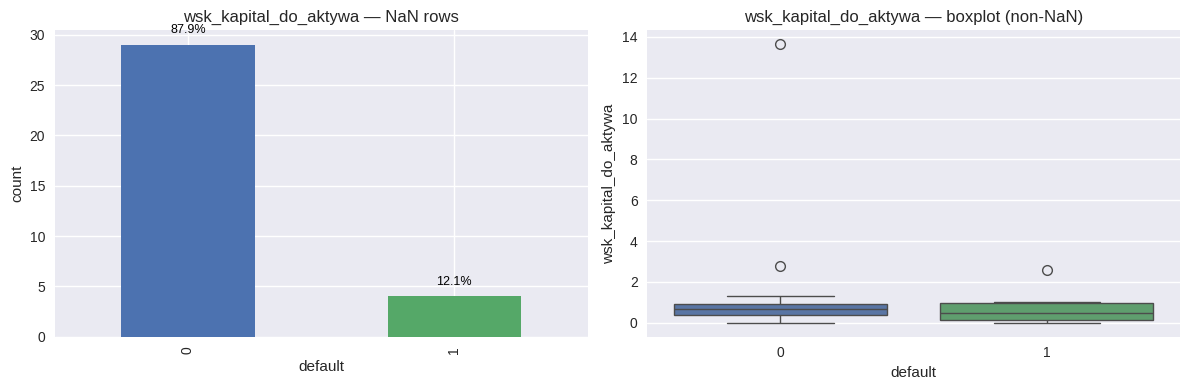

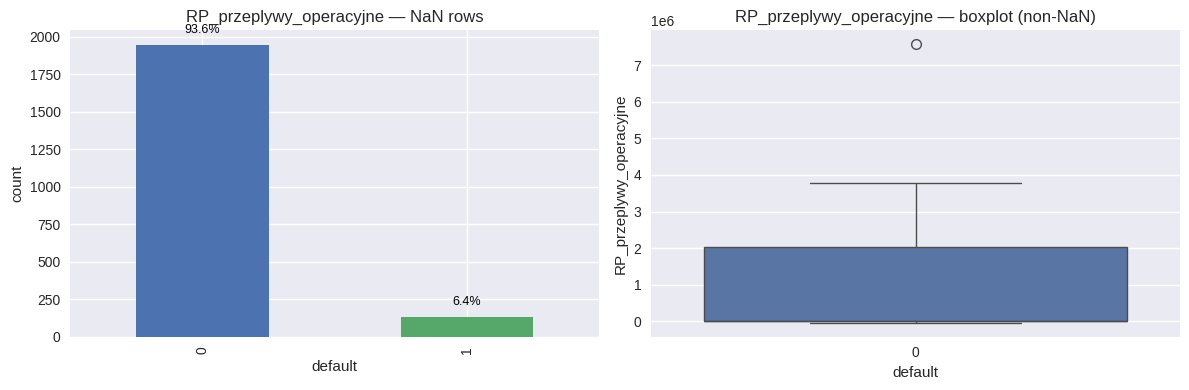

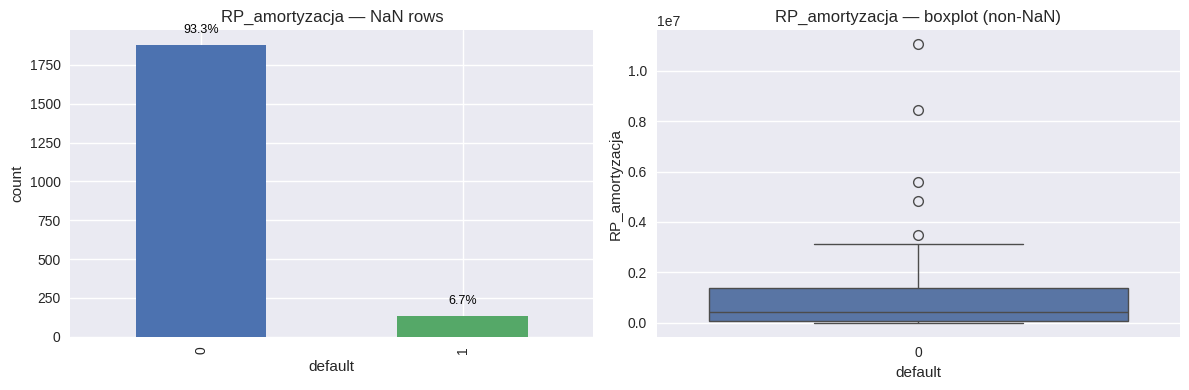

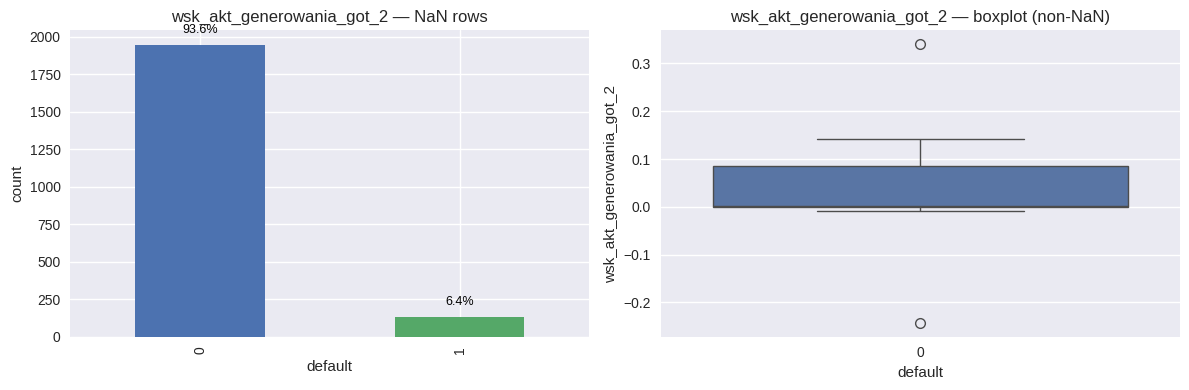

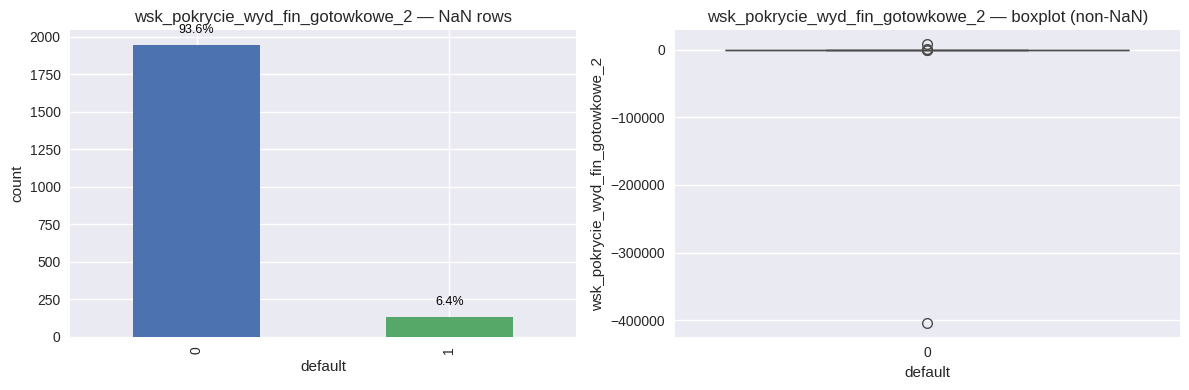

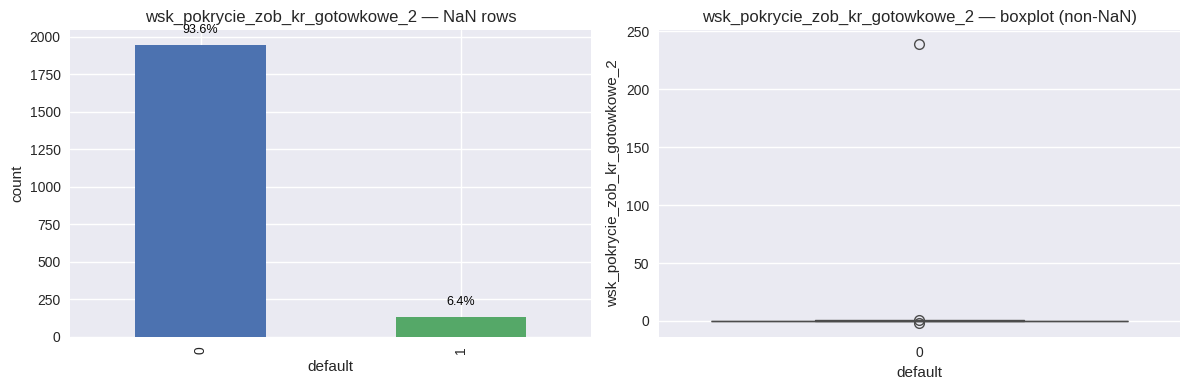

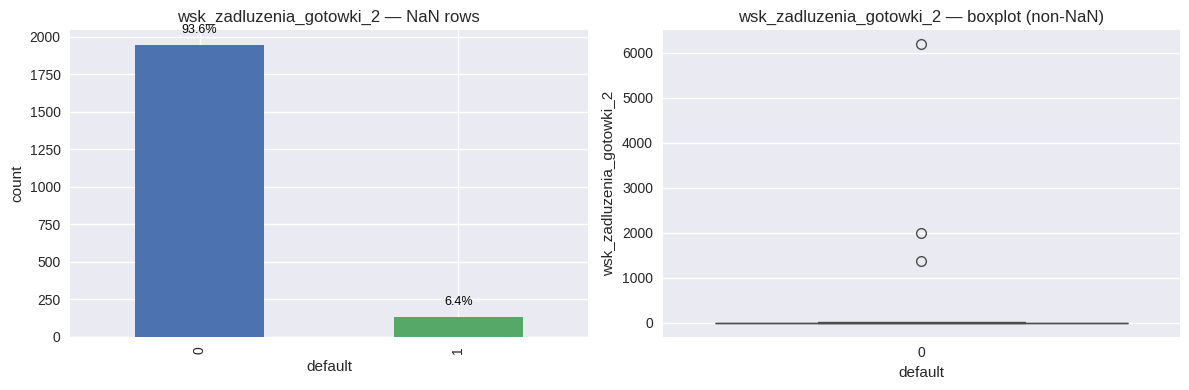

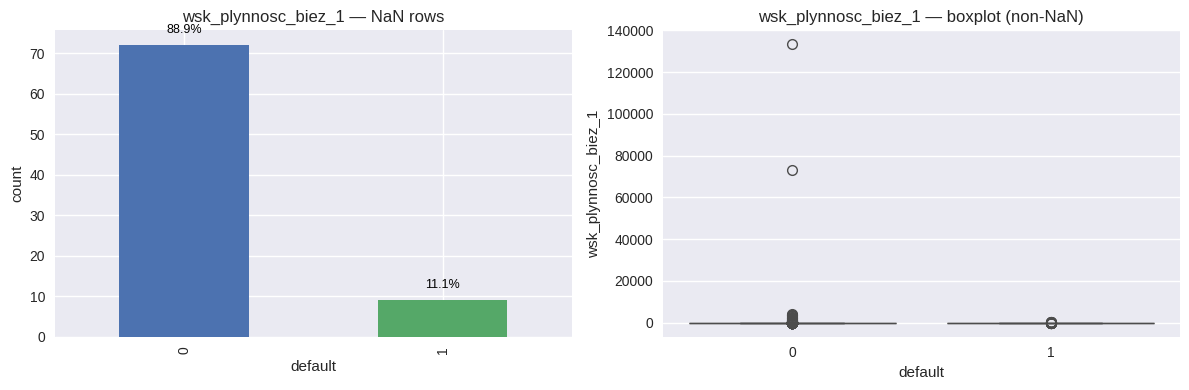

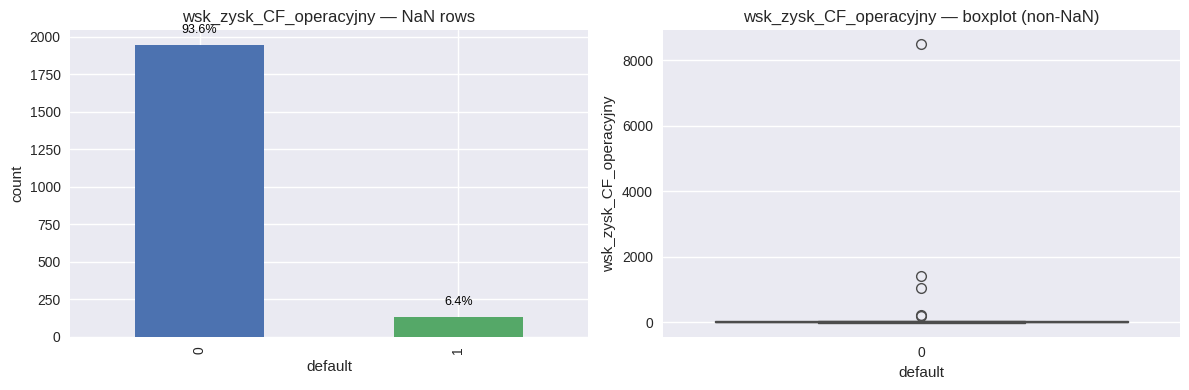

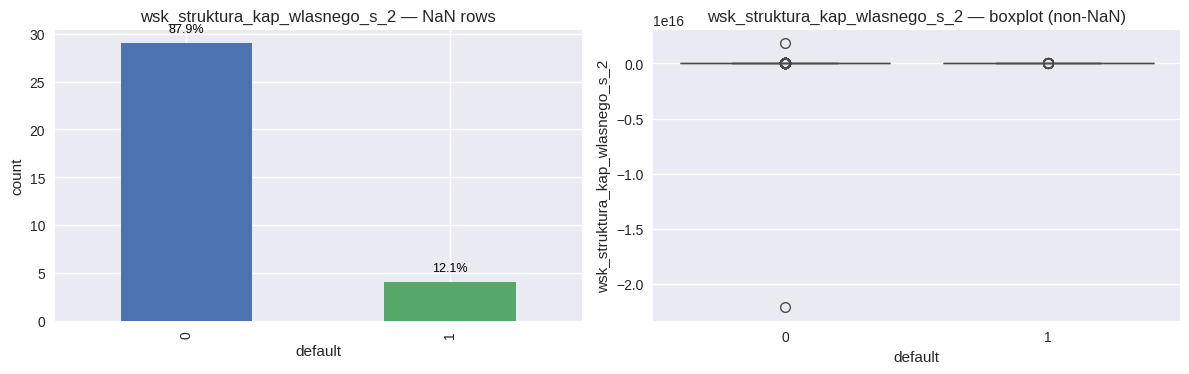

In [52]:
for col in kolumny_do_plotu:
    plt.figure(figsize=(12, 4))

    vals_nan = df_train[df_train[col].isna()]["default"].value_counts().reindex([0,1], fill_value=0)
    vals_notnan = df_train[df_train[col].notna()]["default"].value_counts().reindex([0,1], fill_value=0)

    ax1 = plt.subplot(1, 2, 1)
    vals_nan.plot(kind='bar', ax=ax1, color=['C0', 'C1'])
    ax1.set_title(f"{col} — NaN rows")
    ax1.set_xlabel("default")
    ax1.set_ylabel("count")

    total_nan = vals_nan.sum()
    if total_nan > 0:
        pct_vals = (vals_nan / total_nan) * 100
        y_offset = max(vals_nan) * 0.03 if max(vals_nan) > 0 else 0.5
        for i, (count, pct) in enumerate(zip(vals_nan.values, pct_vals.values)):
            ax1.text(i, count + y_offset, f"{pct:.1f}%", ha='center', va='bottom', fontsize=9, color='black')

    ax2 = plt.subplot(1, 2, 2)
    df_non = df_train[df_train[col].notna()]

    try:
        sns.boxplot(x="default", y=col, data=df_non, ax=ax2, palette=['C0', 'C1'])
        ax2.set_title(f"{col} — boxplot (non-NaN)")
        ax2.set_xlabel("default")
        ax2.set_ylabel(col)
    except Exception:
        ax2.text(0.5, 0.5, f"Cannot plot boxplot for {col}", ha='center', va='center')
        ax2.set_title(f"{col} — boxplot failed")
        ax2.set_xlabel("")
        ax2.set_ylabel("")

    plt.tight_layout()
    plt.show()


Co widzimy?

proporcja w przypadkach gdzie brakuje dużo wartości zgadza się z tendencją 6.4% obliczoną wcześniej, natomiast w przypadku małej ilości braków w kolumnach, nie ma wystarczająco dużo rozbieżności w wykresie dla istniejących danych, nie bierzemy ich więc też pod uwagę

In [53]:
dropped_cols.extend(kolumny_do_plotu)
df_train =df_train.drop(columns=kolumny_do_plotu)
X_train = X_train.drop(columns=kolumny_do_plotu)
kolumny_do_plotu

['wsk_kapital_do_aktywa',
 'RP_przeplywy_operacyjne',
 'RP_amortyzacja',
 'wsk_akt_generowania_got_2',
 'wsk_pokrycie_wyd_fin_gotowkowe_2',
 'wsk_pokrycie_zob_kr_gotowkowe_2',
 'wsk_zadluzenia_gotowki_2',
 'wsk_plynnosc_biez_1',
 'wsk_zysk_CF_operacyjny',
 'wsk_struktura_kap_wlasnego_s_2']

## wartości odstające

In [54]:
def pokaz_rozklad_wzgl_y(X, y, kolumna, log_scale=False):
    plt.figure(figsize=(10, 6))

    if pd.api.types.is_numeric_dtype(X[kolumna]):
        data = X[kolumna].copy()

        if log_scale:
            # transformacja logarytmiczna (log(1+x)) — radzi sobie z zerami
            data = np.log1p(data)
            ylabel = f"{kolumna} (log1p)"
        else:
            ylabel = kolumna

        sns.boxplot(x=y, y=data)
        plt.title(f"Boxplot zmiennej numerycznej '{kolumna}' względem targetu")
        plt.xlabel("Target")
        plt.ylabel(ylabel)

    else:
        # countplot dla kategorii
        sns.countplot(x=X[kolumna], hue=y)
        plt.title(f"Rozkład zmiennej kategorycznej '{kolumna}' względem targetu")
        plt.xlabel(kolumna)
        plt.ylabel("Liczność")
        plt.xticks(rotation=45)

        if log_scale:
            plt.yscale("log")

    plt.tight_layout()
    plt.show()


In [55]:
kolumny_z_outlierami = []
kolumny_bez_outlierow = []
mala_ilosc_roznych = []
for col in X_train.select_dtypes(include='number').columns:

  if X_train[col].nunique() <= 10:
    mala_ilosc_roznych.append(col)
    continue

  skewness = X_train[col].skew()

  # liczymy IQR
  k1 = X_train[col].quantile(0.25)
  k2 = X_train[col].quantile(0.75)
  IQR =  k2-k1
  low = k1 - 1.5 * IQR
  high = k2 + 1.5 * IQR

  outlier_rate = ((X_train[col] < low) | (X_train[col] > high)).mean()

  if outlier_rate > 0.01:
    kolumny_z_outlierami.append(col)
  else:
    kolumny_bez_outlierow.append(col)

print(len(kolumny_z_outlierami))
print(len(kolumny_bez_outlierow))
print(len(mala_ilosc_roznych))

print(len(X_train.select_dtypes(include='number').columns))

188
13
6
207


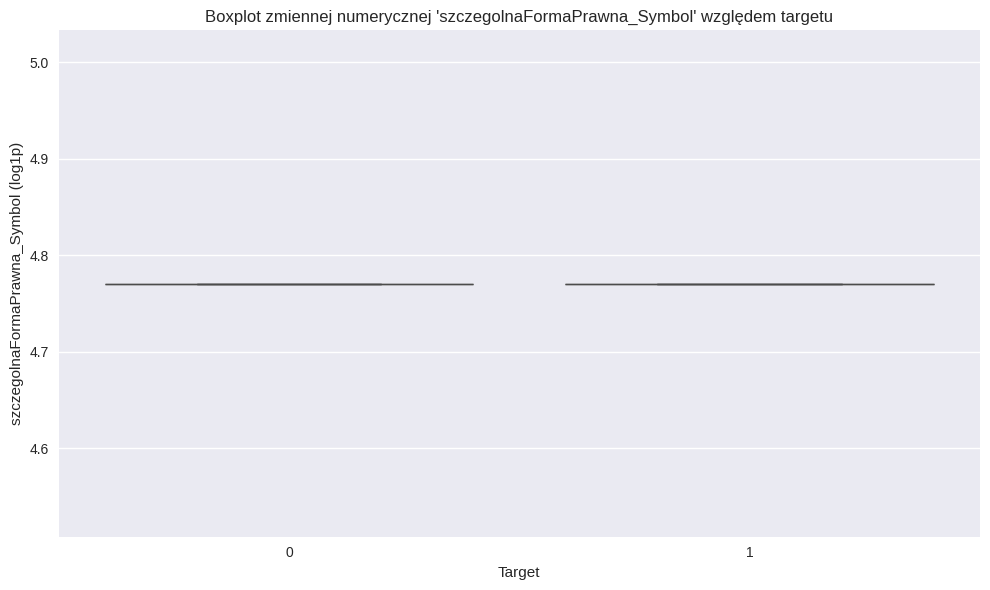

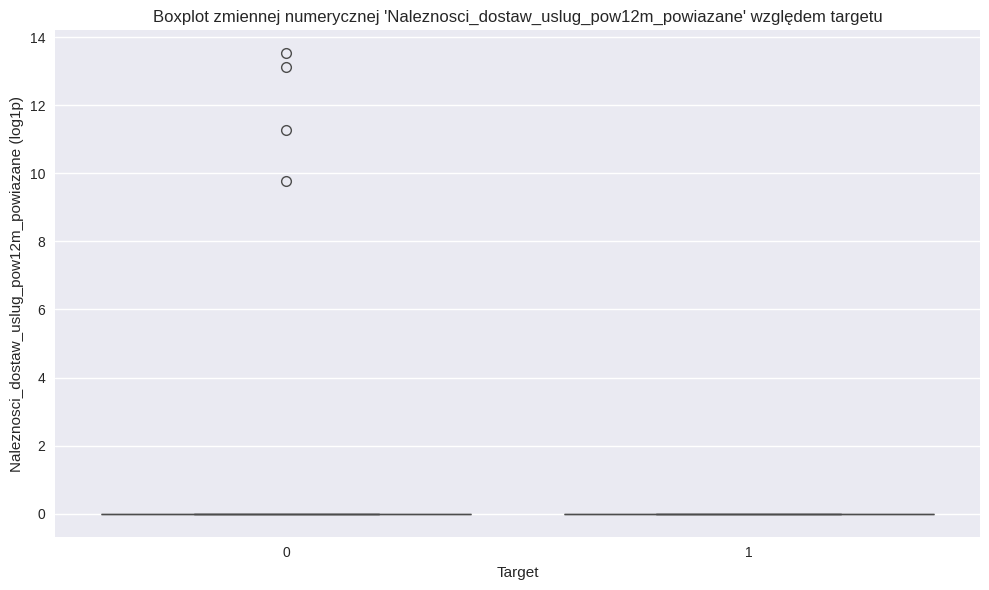

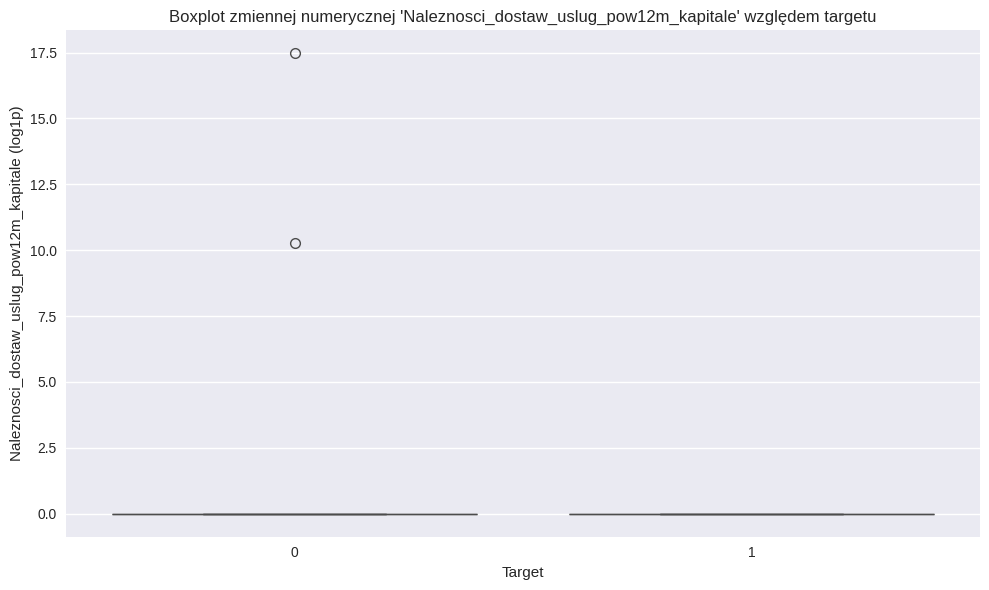

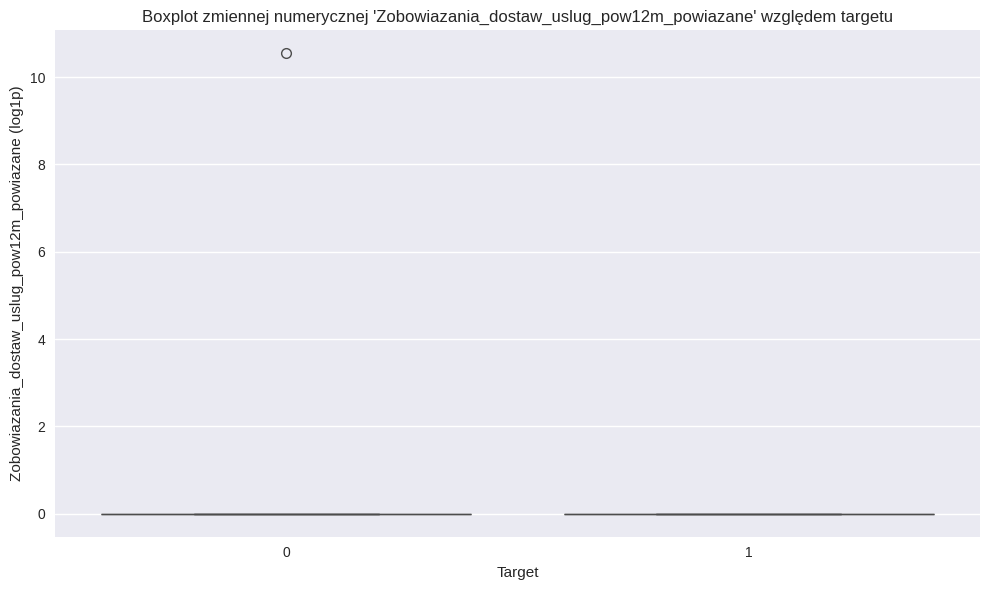

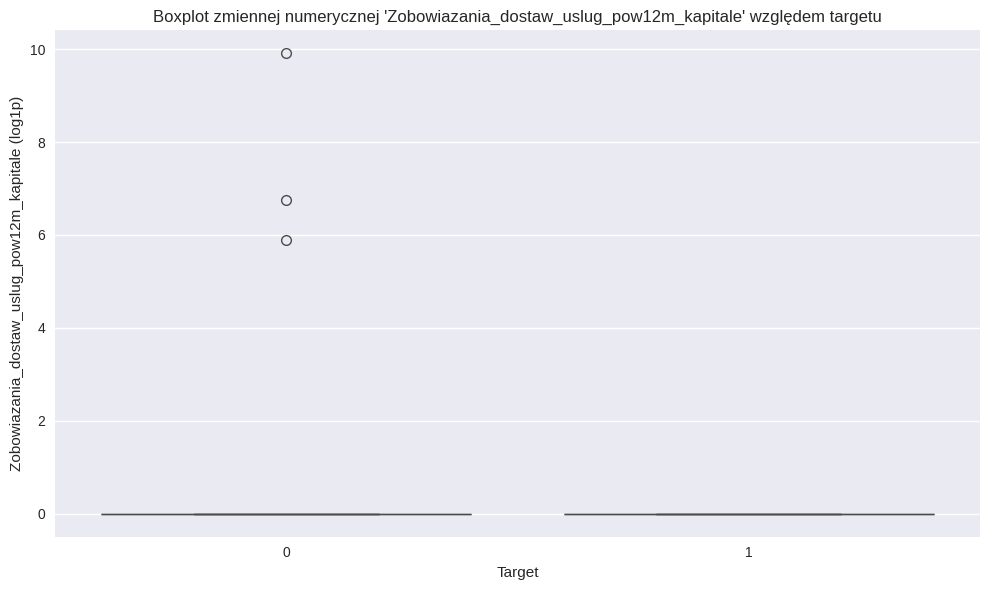

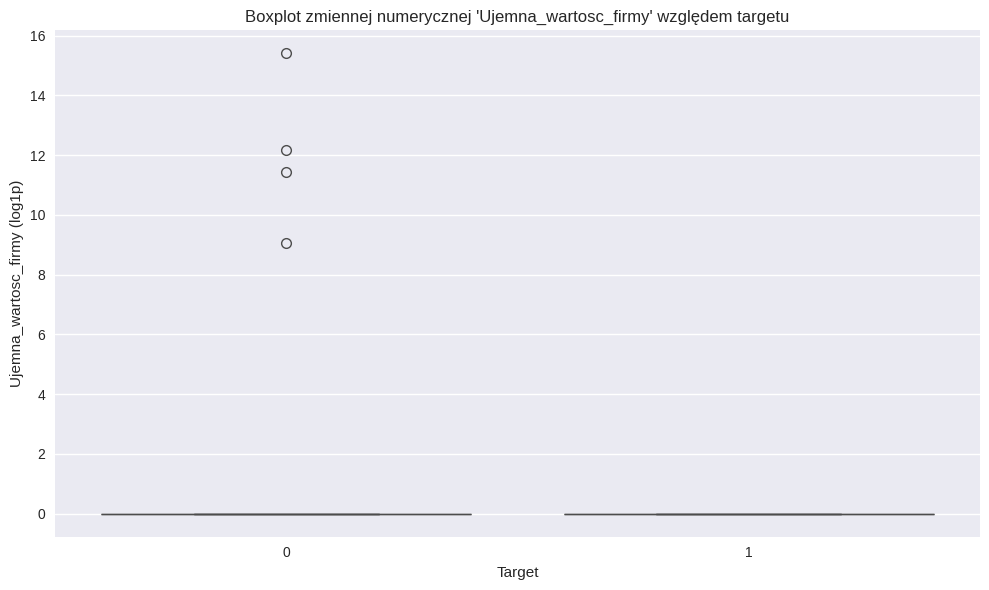

In [56]:
for col in mala_ilosc_roznych:
    pokaz_rozklad_wzgl_y(X_train, y_train, col, log_scale=True)

mała różnica pomiędzy rozkładami - usuwamy te kolummny

In [57]:
X_train= X_train.drop(columns= mala_ilosc_roznych)
dropped_cols.extend(mala_ilosc_roznych)

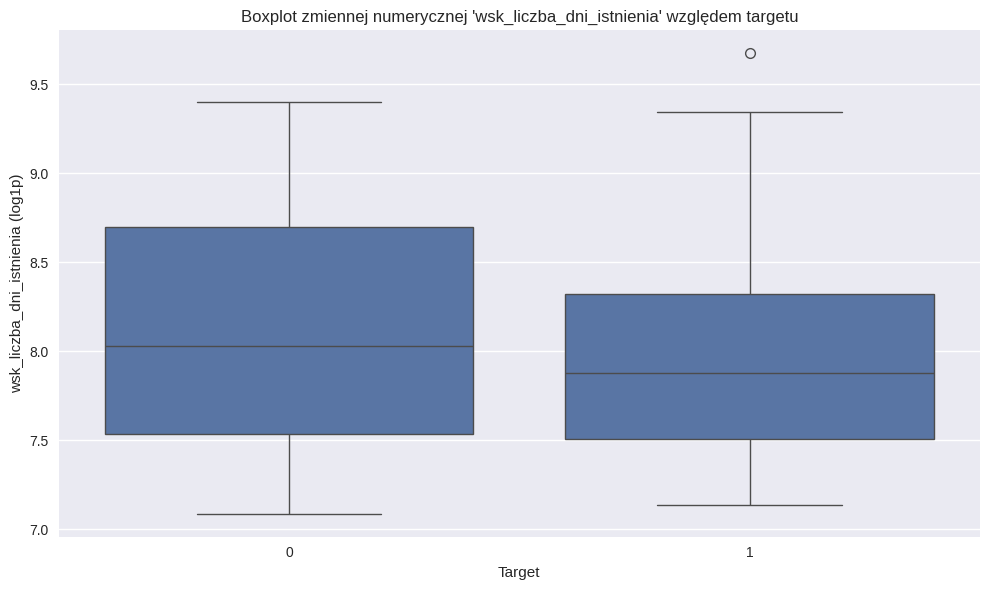

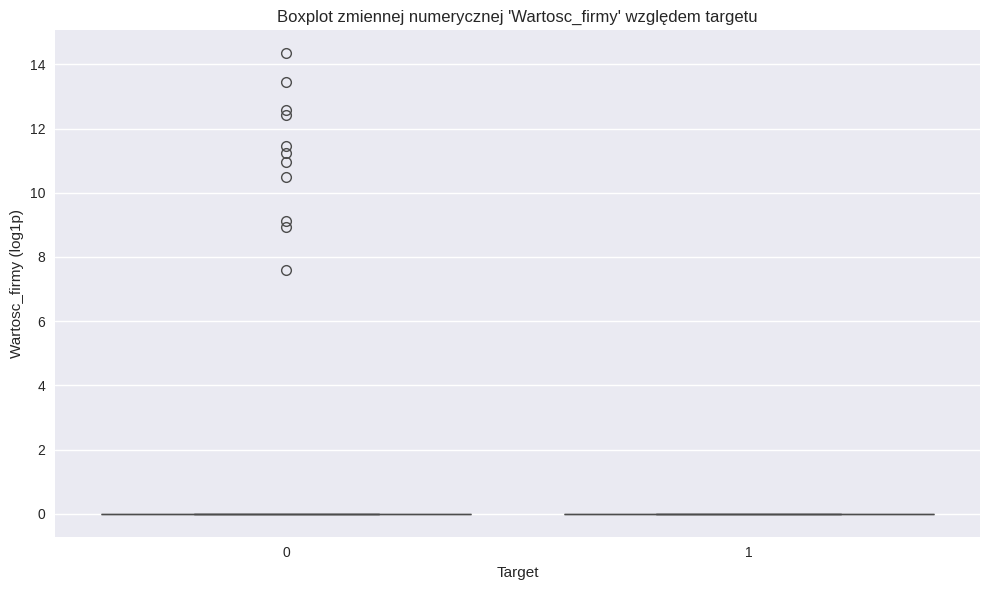

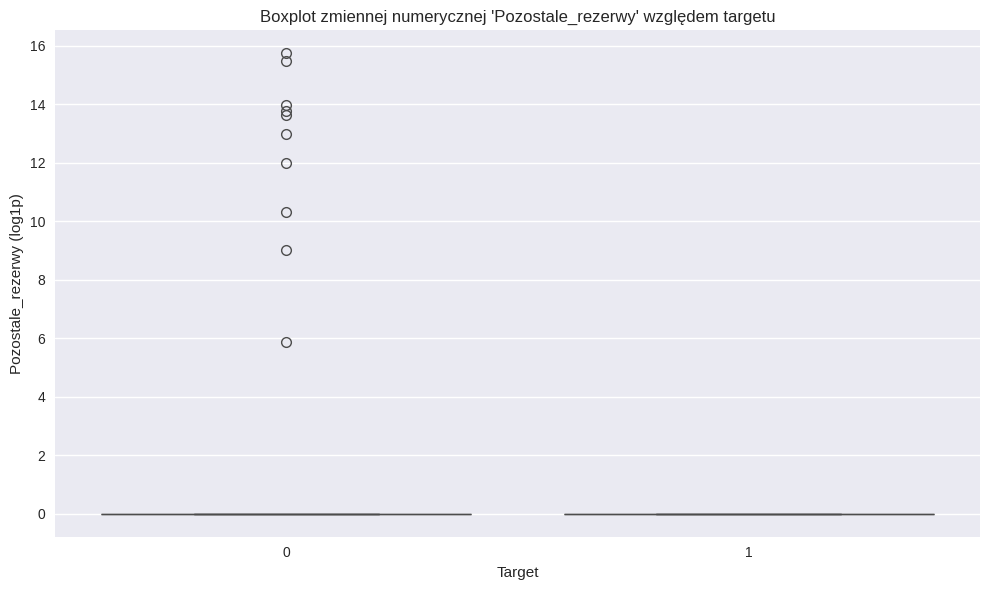

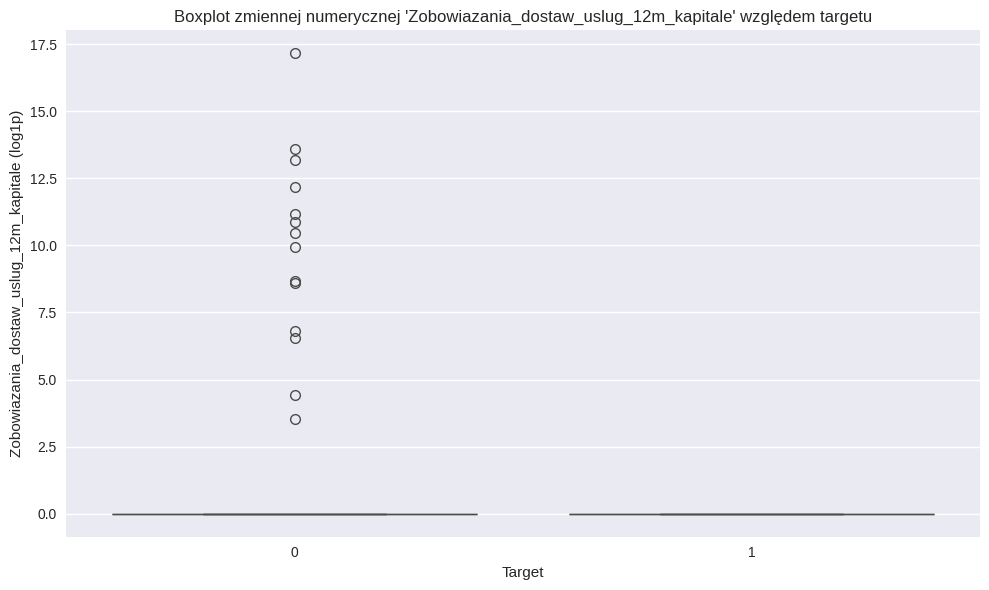

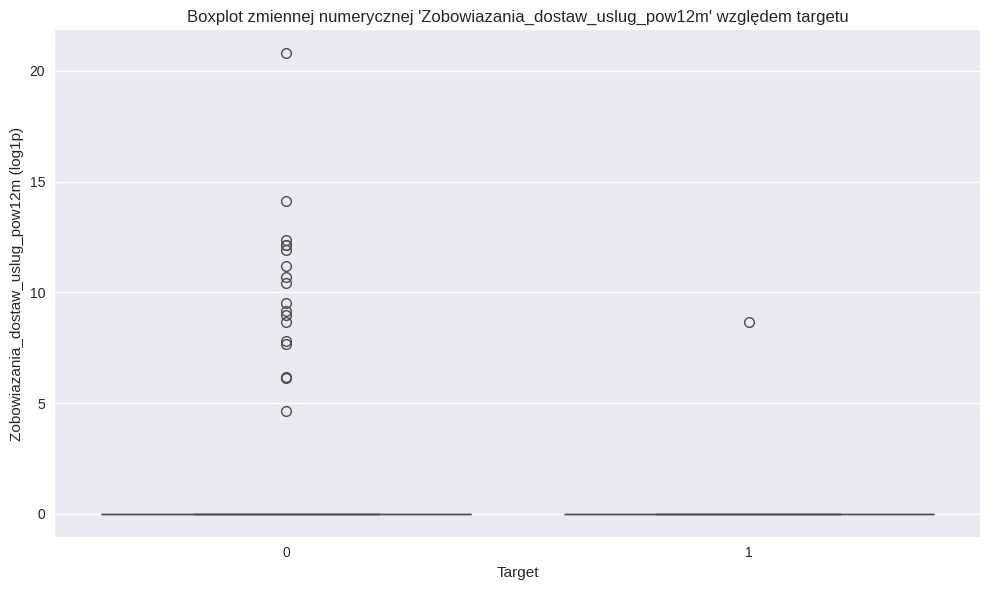

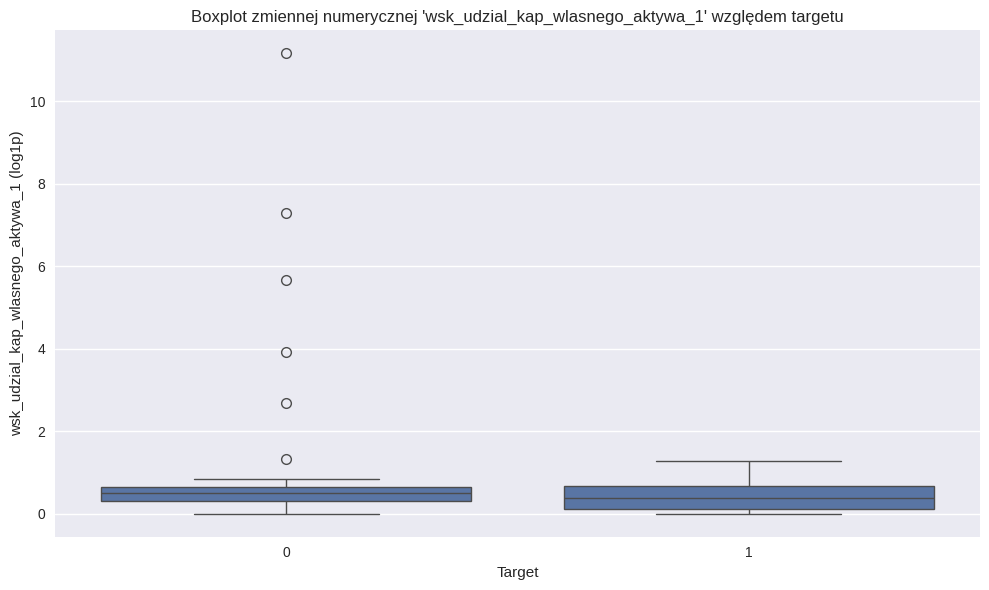

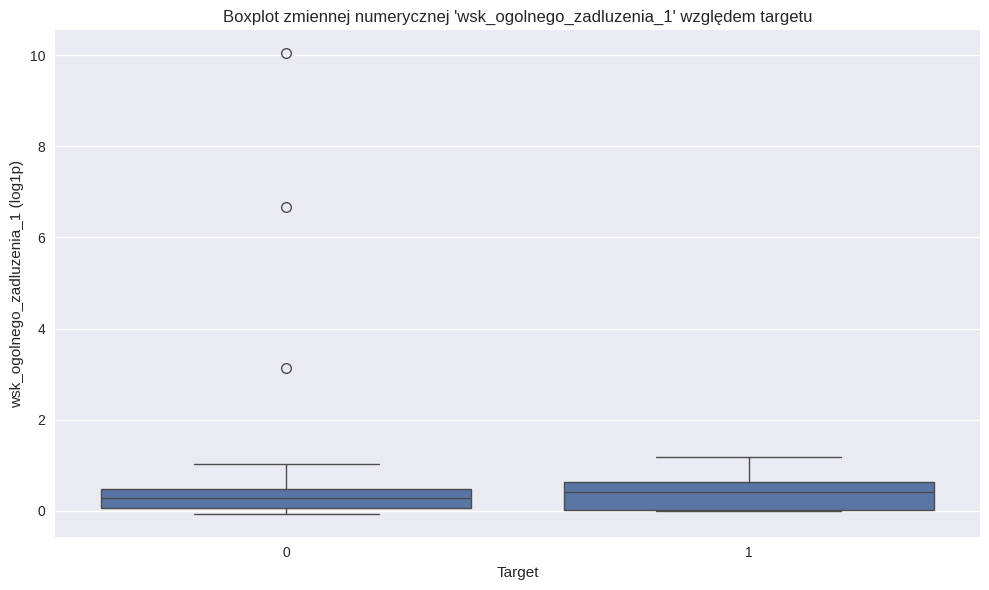

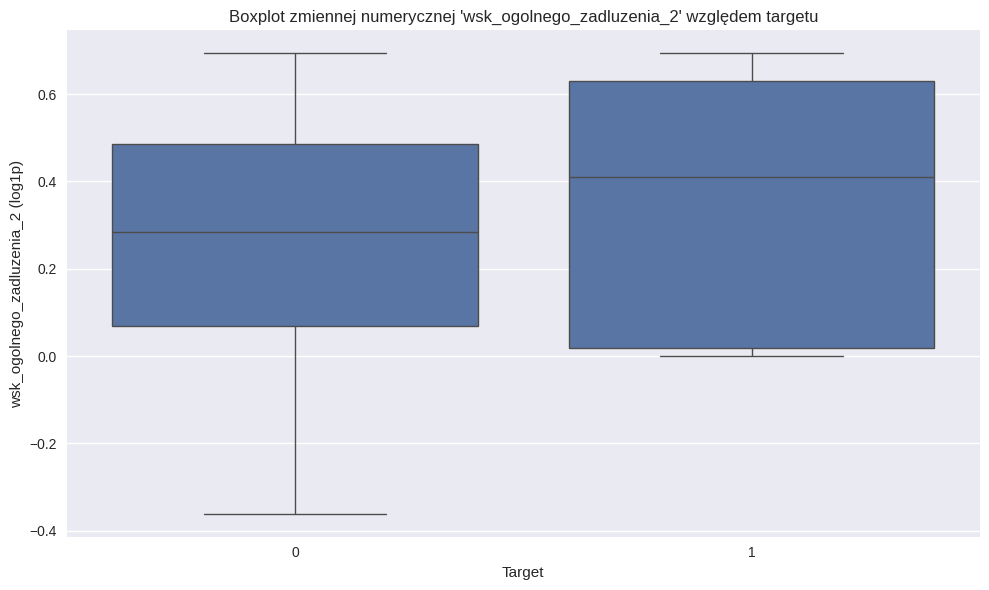

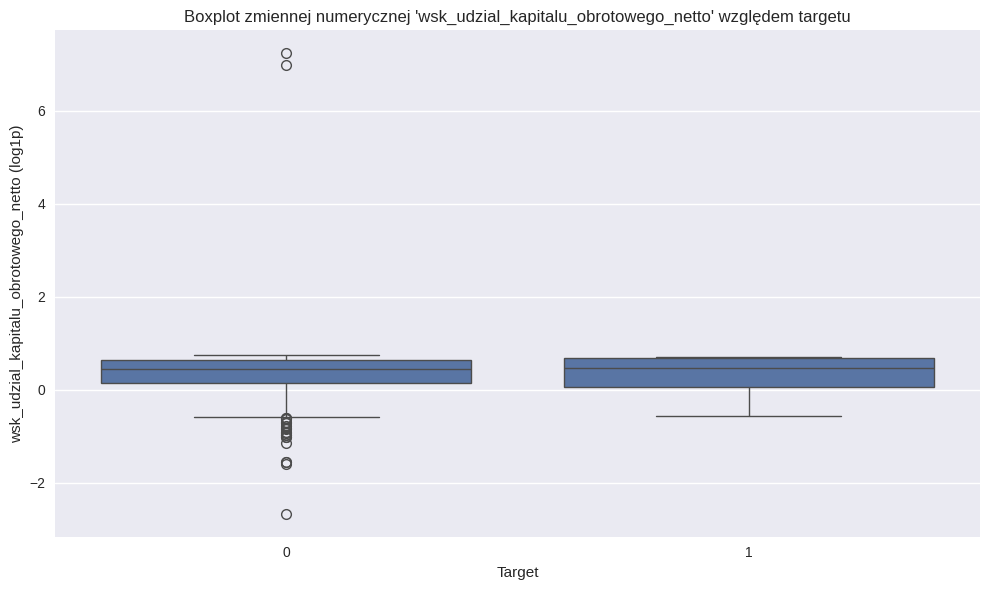

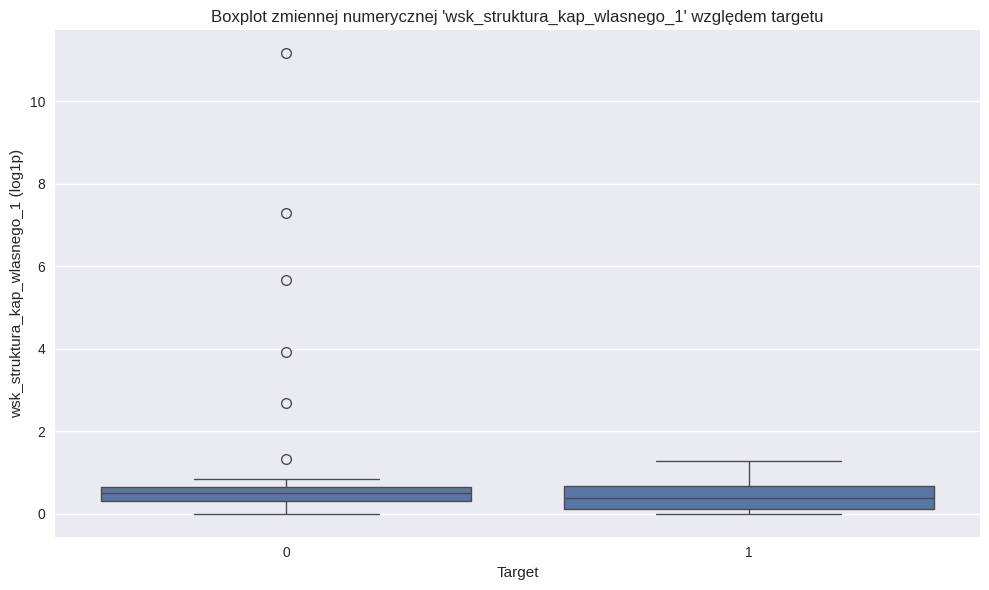

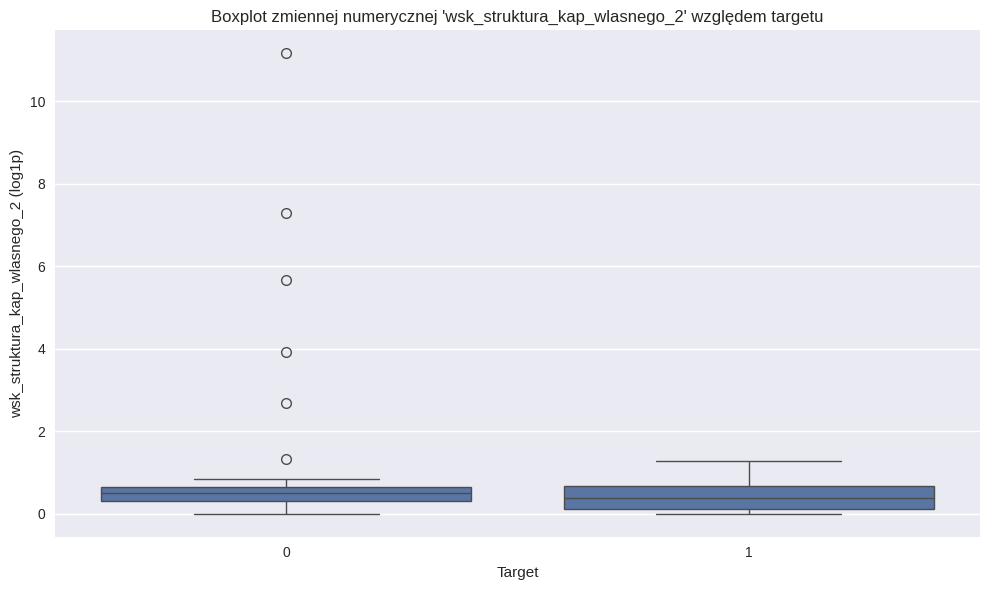

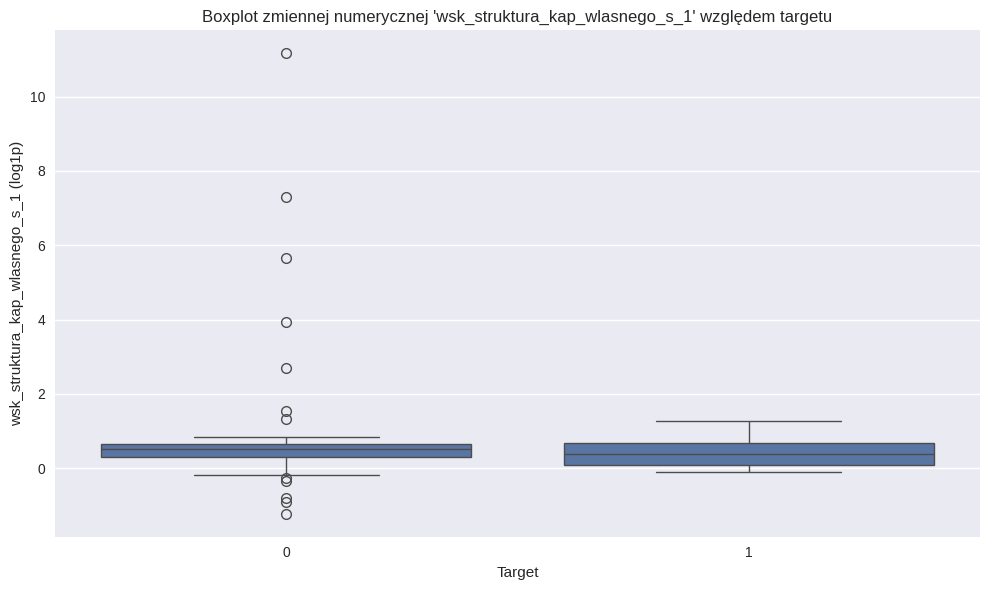

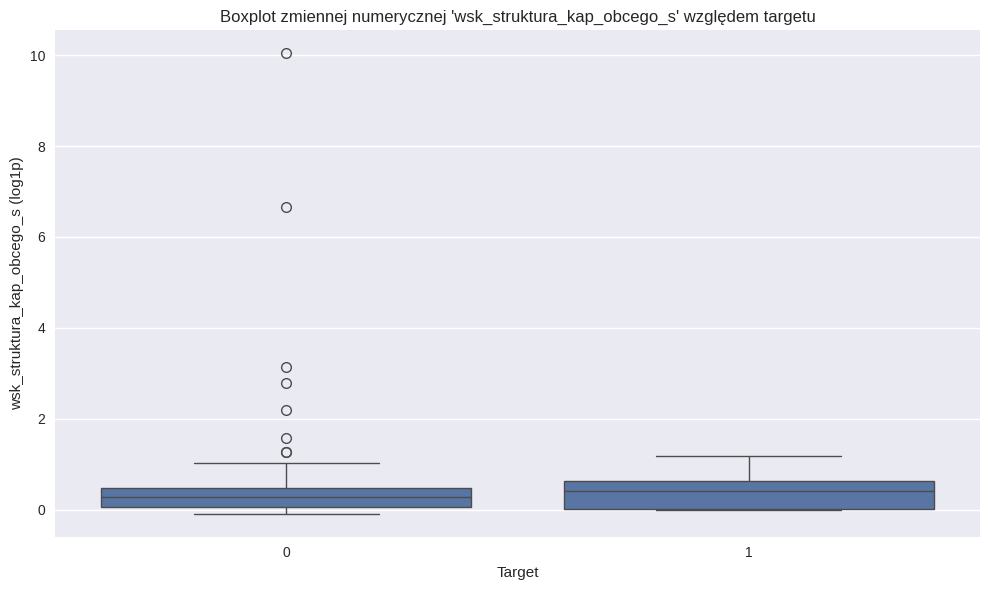

In [58]:
for col in kolumny_bez_outlierow:
    pokaz_rozklad_wzgl_y(X_train, y_train, col, log_scale=True)

nie usuwamy kolumn - na razie nie mamy podstaw

In [59]:
skewness = X_train[kolumny_z_outlierami].skew()
skewed_df = pd.DataFrame(skewness, columns=['Skewness']).sort_values(by='Skewness', ascending=False)

skosne = skewed_df[abs(skewed_df['Skewness']) > 0.5]
print("\nFeatures with high skewness:")
print(skosne)



Features with high skewness:
                                                   Skewness
wsk_rotacja_aktywow_2                             45.825738
wsk_zob_oprocentowanych                           45.825716
wsk_udzial_zob_biez_aktywa_1                      45.825679
wsk_zob_oprocentowanych_aktywa_rzeczowe           45.825675
Naleznosci_dostaw_uslug_pow12m                    45.824641
wsk_rotacja_naleznosci                            45.823508
wsk_cykl_operacyjny                               45.823382
wsk_cykl_konwersji_gotowki                        45.822301
wsk_ebitda_zobowiazan_odsetki_4                   45.818698
wsk_udzial_zob_biez_sprzedaz_1                    45.816848
wsk_rotacja_zobowiazan                            45.816824
wsk_udzial_kap_wlasnego_aktywa_2                  45.796618
wsk_struktury_finansowania                        45.789984
wsk_udzial_zob_biez_aktywa_2                      45.789284
wsk_koszt_długu_2                                 45.668485
Naleznosci

In [60]:
for col in kolumny_z_outlierami:
    low = X_train[col].quantile(0.05)
    high = X_train[col].quantile(0.95)
    X_train[col] = X_train[col].clip(lower=low, upper=high)



In [61]:
skewness = X_train[kolumny_z_outlierami].skew()
skewed_df = pd.DataFrame(skewness, columns=['Skewness']).sort_values(by='Skewness', ascending=False)

skosne = skewed_df[abs(skewed_df['Skewness']) > 0.5]
print("\nFeatures with high skewness:")
print(skosne)



Features with high skewness:
                                              Skewness
Kredyty_pozyczki                              3.945831
Naleznosci_dostaw_uslug_12m_powiazane         3.928473
Zobowiazania_dostaw_uslug_12m_powiazane       3.858033
Rozliczenia_miedzyokresowe_dlugie             3.792600
wsk_udzial_zapasy_zobowiazania                3.767045
dotacje                                       3.744369
Rezerwy_na_zobowiazania                       3.705367
wsk_koszt_długu_1                             3.654075
wsk_rotacja_zobowiazan_dostaw_uslug           3.649402
wsk_koszt_długu_2                             3.578456
Inne_rozliczenia_miedzyokresowe_krotkie       3.550566
Inwestycje_dlugoterminowe                     3.536942
wsk_udzial_zob_biez_sprzedaz_1                3.531901
wsk_rotacja_zobowiazan                        3.531210
wsk_cykl_konwersji_gotowki                    3.522417
wsk_cykl_operacyjny                           3.503116
Wartosci_niematerialne_prawne      

dużo kolumn bardzo skośnych

In [62]:
num_cols = X_train.select_dtypes(include="number").columns
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])

In [63]:
colnames = X_train.nunique()[X_train.nunique() == 1].index.tolist()
dropped_cols.extend(colnames)
X_train = X_train.drop(columns=colnames)
l_unikatow = X_train.nunique()
potencjalne_kategoryczne = l_unikatow[l_unikatow < 30] # kandydaci do dyskretyzacji
print(potencjalne_kategoryczne)


formaWlasnosci_Symbol                     10
Wartosc_firmy                             12
Pozostale_rezerwy                         11
Zobowiazania_dostaw_uslug_12m_kapitale    15
schemat_wsk_bilans                         3
Zobowiazania_dostaw_uslug_pow12m          19
Kredyty_pozyczki                          26
schemat_wsk_rzis                           3
dtype: int64


In [64]:
wyniki_chi2 = []
niewazne = []
wartosc_krytyczna = 0.05

for col in potencjalne_kategoryczne.index.tolist():

    # --- KOPIA kolumny, żeby NIE zmieniać X_train ---
    temp_col = X_train[col].copy()

    # --- KROK 1: DYSKRETYZACJA / KONWERSJA ---
    if pd.api.types.is_numeric_dtype(temp_col):
        unique_vals = temp_col.nunique()

        if unique_vals > 15:
            temp_col = pd.qcut(temp_col, q=15, duplicates='drop')
        else:
            temp_col = temp_col.astype('category')
    else:
        temp_col = temp_col.astype('category')

    # --- KROK 2: TABELA KONTYNGENCJI ---
    contingency_table = pd.crosstab(temp_col, y_train)

    # Jeżeli któraś kategoria nie ma obserwacji → pominięcie
    if contingency_table.shape[0] < 2:
        wyniki_chi2.append({
            "zmienna": col,
            "chi2": None,
            "p_value": None,
            "decyzyjnosc": "pominięto (zbyt mało kategorii)"
        })
        niewazne.append(col)
        continue

    # --- KROK 3: TEST CHI-KWADRAT ---
    chi2_val, p, dof, expected = chi2_contingency(contingency_table)

    wyniki_chi2.append({
        "zmienna": col,
        "chi2": chi2_val,
        "p_value": p,
        "decyzyjnosc": "TAK" if p < wartosc_krytyczna else "NIE"
    })

# --- KROK 4: DataFrame wyników ---
wyniki_chi2_df = pd.DataFrame(wyniki_chi2).sort_values("p_value")

wyniki_chi2_df

,zmienna,chi2,p_value,decyzyjnosc
7,schemat_wsk_rzis,6.678658,0.035461,TAK
4,schemat_wsk_bilans,4.176685,0.123892,NIE
0,formaWlasnosci_Symbol,4.361887,0.886022,NIE
2,Pozostale_rezerwy,0.684848,0.999970,NIE
1,Wartosc_firmy,0.753694,0.999988,NIE
3,Zobowiazania_dostaw_uslug_12m_kapitale,0.960626,0.999999,NIE
5,Zobowiazania_dostaw_uslug_pow12m,NaN,NaN,pominięto (zbyt mało kategorii)
6,Kredyty_pozyczki,NaN,NaN,pominięto (zbyt mało kategorii)


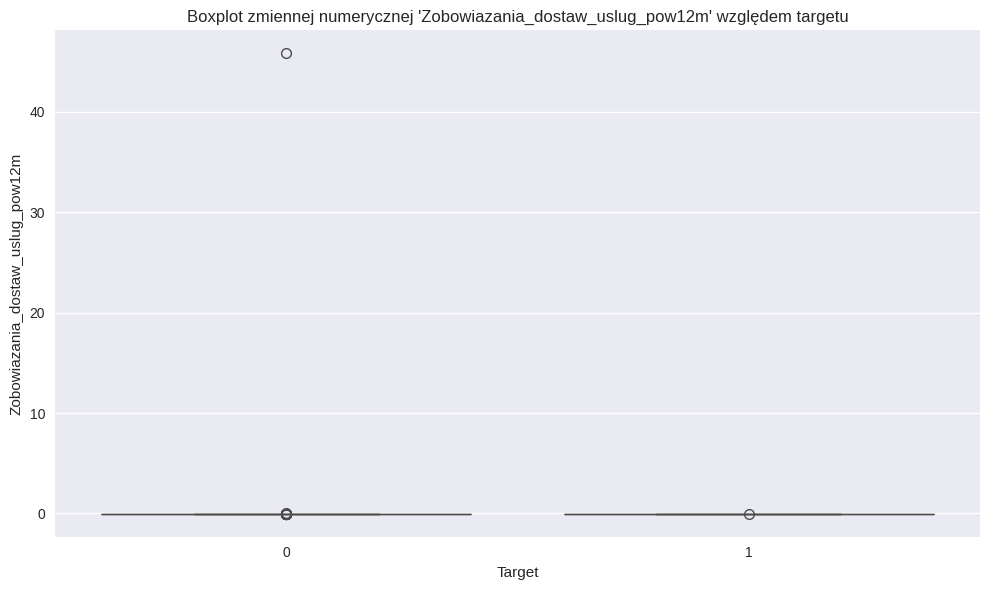

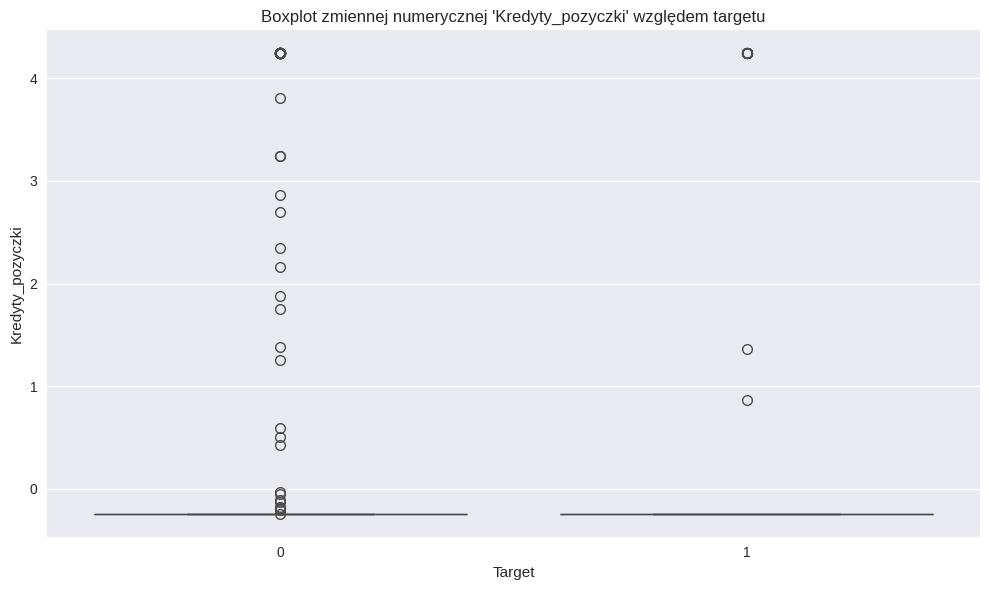

In [65]:
for i in niewazne:
  pokaz_rozklad_wzgl_y(X_train, y_train, i)

## wartości kategorycznne

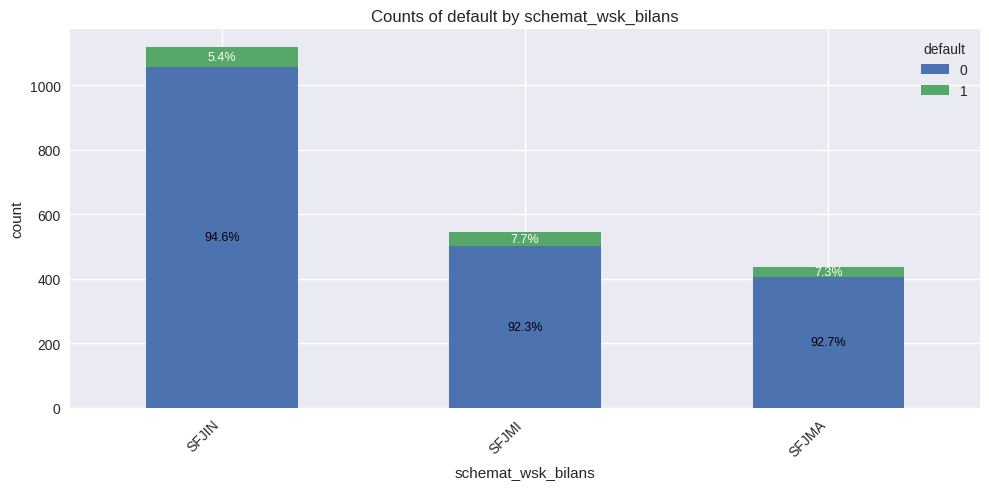

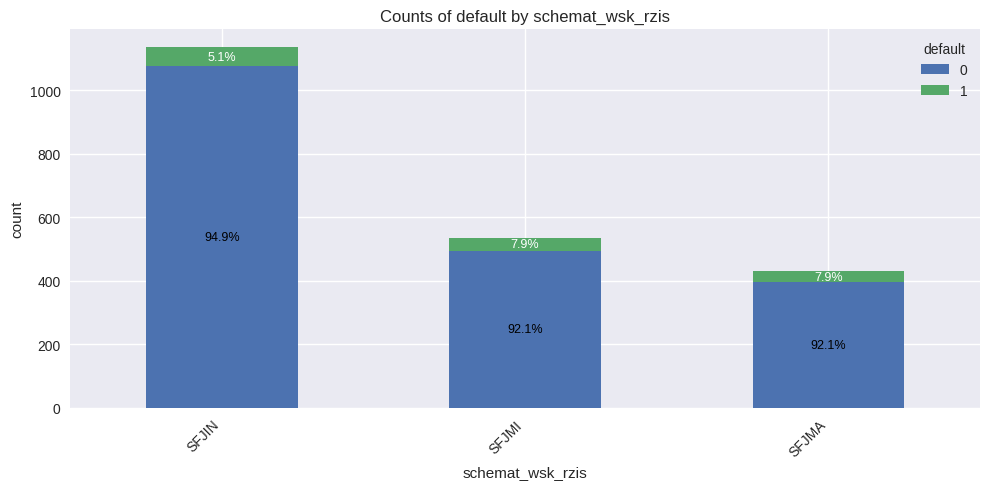

In [66]:
cols_nonnumer = X_train.select_dtypes(exclude='number').columns.tolist()

for col in cols_nonnumer:
    series = df_train[col].fillna('NaN')
    ct = pd.crosstab(series, df_train['default'])
    for val in [0, 1]:
        if val not in ct.columns:
            ct[val] = 0
    ct = ct[[0, 1]]

    ct['total'] = ct.sum(axis=1)
    ct = ct.sort_values(by='total', ascending=False)
    totals = ct['total']
    ct = ct.drop(columns='total')

    ax = ct.plot(kind='bar', figsize=(10, 5), color=['C0', 'C1'], stacked=True)
    ax.set_xlabel(col)
    ax.set_ylabel('count')
    ax.set_title(f'Counts of default by {col}')
    ax.legend(title='default')
    plt.xticks(rotation=45, ha='right')

    # procenty dla każdego segmentu (0 i 1) w każdej kategorii
    pct = ct.div(ct.sum(axis=1), axis=0) * 100

    for i, (idx, row) in enumerate(ct.iterrows()):
        y_bottom = 0
        for j, lbl in enumerate([0, 1]):
            h = row[lbl]
            if h == 0:
                continue
            text = f"{pct.loc[idx, lbl]:.1f}%"
            ax.text(i, y_bottom + h / 2, text, ha='center', va='center',
                    color='white' if lbl == 1 else 'black', fontsize=9)
            y_bottom += h

    plt.tight_layout()
    plt.show()

In [68]:
cols_nonnumer = X_train.select_dtypes(exclude='number').columns.tolist()
X_train = X_train.drop(columns=cols_nonnumer)

Zostają nam tylko kolumny numeryczne

In [73]:
X_train.dtypes

formaWlasnosci_Symbol                           float64
pkdKod                                          float64
wsk_liczba_dni_istnienia                        float64
Aktywa                                          float64
Aktywa_trwale                                   float64
Wartosci_niematerialne_prawne                   float64
Wartosc_firmy                                   float64
Rzeczowe_aktywa_trwale                          float64
Srodki_trwale                                   float64
Inwestycje_dlugoterminowe                       float64
Rozliczenia_miedzyokresowe_dlugie               float64
Aktywa_obrotowe                                 float64
Zapasy                                          float64
Naleznosci_krotkoterminowe                      float64
Naleznosci_dostaw_uslug_12m_powiazane           float64
Naleznosci_dostaw_uslug_12m_pozostale           float64
Inwestycje_krotkoterminowe                      float64
Srodki_pieniezne                                

All features ordered by absolute correlation with 'default':
['wsk_zadluzenia', 'wsk_zadluzenie_kap_wlasnego', 'wsk_mnoznik_kap_wl', 'wsk_ROE', 'wsk_s_ROE']... (first 5)

Generowanie wykresu pudełkowego dla wybranej cechy: 'wsk_zadluzenia' w stosunku do statusu 'default':


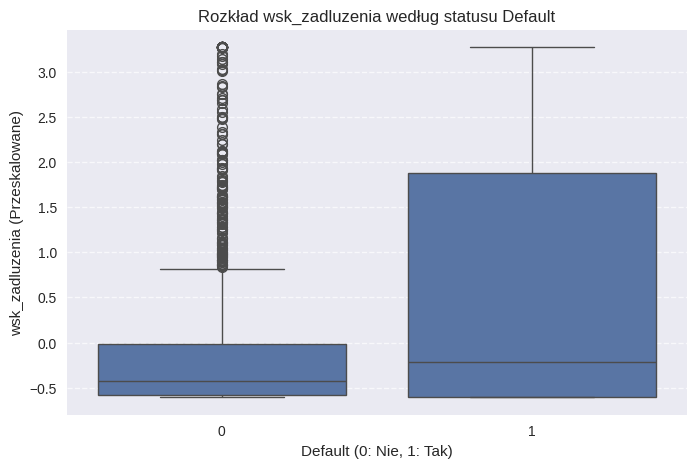


Aby wykreślić inną kolumnę, zmień wartość zmiennej 'selected_feature' na inną nazwę kolumny z powyższej listy.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Zakładamy, że X_train i y_train zostały już zdefiniowane i X_train jest przeskalowane

# 1. Łączenie danych
df_combined = X_train.copy()
# Upewnienie się, że 'default' jest numeryczne (kluczowe, często jest int/float)
df_combined['default'] = y_train.astype(float) # Upewniamy się, że zmienna docelowa jest float

# --- NOWY KROK NAPRAWIAJĄCY BŁĄD ---
# Wybieramy tylko kolumny, które są numeryczne, aby uniknąć ValueError.
# W zbiorze danych mogą pozostać kategoryczne kolumny z wartościami string.
numerical_cols_for_corr = df_combined.select_dtypes(include=[np.number]).columns
df_numerical = df_combined[numerical_cols_for_corr]

# 2. Obliczanie korelacji
# Używamy teraz tylko ramki z kolumnami numerycznymi.
# Dodatkowe sprawdzenie, czy 'default' jest na pewno w df_numerical (powinien być).
if 'default' not in df_numerical.columns:
    print("Błąd: Kolumna 'default' została usunięta lub nie jest numeryczna po selekcji typów.")
    # Możesz tutaj dodać kod do dalszego debugowania

correlations = df_numerical.corr()['default'].abs().sort_values(ascending=False)

# 3. Czyszczenie i porządkowanie
# Drop 'default' z korelacji, ponieważ korelacja zmiennej ze sobą samą wynosi 1.0.
# Oczekujemy, że 'default' jest pierwszym elementem, ale sprawdzamy to bezpiecznie.
if 'default' in correlations.index:
    correlations = correlations.drop('default')

# Get the list of all features, ordered by correlation (most correlated first)
all_features_by_corr = correlations.index.tolist()

print(f"All features ordered by absolute correlation with 'default':")
print(f"{all_features_by_corr[:5]}... (first 5)\n")

# --- Select a specific feature to plot ---
# Wybieramy cechę z listy cech NUMERYCZNYCH i skorelowanych
selected_feature = all_features_by_corr[0]

print(f"Generowanie wykresu pudełkowego dla wybranej cechy: '{selected_feature}' w stosunku do statusu 'default':")

plt.figure(figsize=(8, 5))
# Używamy X_train, ponieważ jest to oryginalna, skalowana ramka danych dla cech.
# WAŻNE: Upewnij się, że y_train ma odpowiedni format (0/1) dla osi X.
sns.boxplot(x=y_train, y=X_train[selected_feature])
plt.title(f'Rozkład {selected_feature} według statusu Default')
plt.xlabel('Default (0: Nie, 1: Tak)')
plt.ylabel(f'{selected_feature} (Przeskalowane)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(f"\nAby wykreślić inną kolumnę, zmień wartość zmiennej 'selected_feature' na inną nazwę kolumny z powyższej listy.")

In [ ]:
from sklearn.preprocessing import PowerTransformer

In [ ]:
# # Transformacja Yeo-Johnson
# df_train_transformed_yj = df_train.copy()

# # Initialize PowerTransformer with Yeo-Johnson method
# pt = PowerTransformer(method='yeo-johnson')

# # Identify numerical columns (excluding the target 'default' if it's still there)
# numerical_cols = df_train_transformed_yj.select_dtypes(include=['number']).columns.tolist()

# # Fit and transform the numerical columns
# df_train_transformed_yj[numerical_cols] = pt.fit_transform(df_train_transformed_yj[numerical_cols])

# print("Yeo-Johnson transformation applied to numerical columns. First 5 rows of transformed DataFrame:")
# print(df_train_transformed_yj.head())

In [ ]:
# === FINALNA, BEZPIECZNA TRANSFORMACJA (winsorize + Yeo-Johnson) ===
# Wklej to zamiast swojego starego kodu transformacji

from sklearn.preprocessing import PowerTransformer
from scipy.stats.mstats import winsorize
import numpy as np

print("Czyszczenie danych i super-transformacja...")

# 1. USUWAMY WSZYSTKIE KOLUMNY TEKSTOWE (SFJMI, SFJMA itp.) – to zabija błąd raz na zawsze
print(f"X_train przed czyszczeniem: {X_train.shape}")

# Zostawiamy TYLKO kolumny numeryczne
X_train = X_train.select_dtypes(include=[np.number]).copy()
X_test  = X_test.select_dtypes(include=[np.number]).copy()

print(f"X_train po usunięciu kolumn tekstowych: {X_train.shape}")
print(f"X_test po czyszczeniu: {X_test.shape}")

# 2. Winsorize 1% + Yeo-Johnson + scaling
pt = PowerTransformer(method='yeo-johnson', standardize=False)

# Na X_train – fitujemy transformację
for col in X_train.columns:
    # Winsorize tylko górny 1% (dolny zostawiamy, bo w kredytach nie ma ujemnych wartości)
    x_w = winsorize(X_train[col].values, limits=[0.0, 0.01])
    x_t = pt.fit_transform(x_w.reshape(-1, 1))
    x_scaled = (x_t - x_t.mean()) / x_t.std()
    X_train[col] = x_scaled.flatten()

# Na X_test – tylko transformujemy (bez fit!)
for col in X_test.columns:
    if col in X_train.columns:  # na wypadek jakby coś zniknęło
        x_w = winsorize(X_test[col].values, limits=[0.0, 0.01])
        x_t = pt.transform(x_w.reshape(-1, 1))
        x_scaled = (x_t - x_t.mean()) / x_t.std()
        X_test[col] = x_scaled.flatten()

print("Transformacja zakończona!")
print(f"Średni |skewness| po transformacji: {X_train.skew().abs().mean():.4f}")
print(f"Max |skewness|: {X_train.skew().abs().max():.4f}")
print("Teraz możesz uruchamiać WSZYSTKO – wykresy, modele, wszystko będzie działać idealnie!")

Czyszczenie danych i super-transformacja...
X_train przed czyszczeniem: (2100, 185)
X_train po usunięciu kolumn tekstowych: (2100, 183)
X_test po czyszczeniu: (900, 217)
Transformacja zakończona!
Średni |skewness| po transformacji: 1.0594
Max |skewness|: 7.7479
Teraz możesz uruchamiać WSZYSTKO – wykresy, modele, wszystko będzie działać idealnie!


## Snapshot Numerical Features for Comparison

### Reasoning:
Before applying the Yeo-Johnson transformation and standard scaling, it's essential to take a snapshot of the current state of numerical features in `X_train`. This `X_train_before_yj_scaling` DataFrame will be used later to compare the distributions of features, allowing us to visually assess the impact of the transformations, as per the updated plan.

In [ ]:
# Create a copy of the current numerical X_train DataFrame
X_train_before_yj_scaling = X_train.copy()

print("Snapshot of numerical features created in 'X_train_before_yj_scaling'.")
print(f"Shape of X_train_before_yj_scaling: {X_train_before_yj_scaling.shape}")

Snapshot of numerical features created in 'X_train_before_yj_scaling'.
Shape of X_train_before_yj_scaling: (2100, 183)


## Apply Yeo-Johnson Transformation

### Reasoning:
Now that a snapshot of the numerical features (`X_train_before_yj_scaling`) has been taken for comparison, the next step in the preprocessing pipeline is to apply the Yeo-Johnson transformation to all numerical columns in `X_train`. This will normalize their distributions, which is a key step in preparing the data for modeling, as specified in the plan.

In [ ]:
# from sklearn.preprocessing import PowerTransformer
# from scipy.stats.mstats import winsorize
# import numpy as np
# import warnings
# warnings.filterwarnings("ignore")

# print("NIEZNISZCZALNA transformacja – działa na wszystkim!")

# # 1. Czyścimy dane z kolumn tekstowych (SFJMI itp.)
# X_train = X_train.select_dtypes(include=[np.number]).copy()
# X_test  = X_test.select_dtypes(include=[np.number]).copy()

# print(f"Start: {X_train.shape[1]} numerycznych cech")

# # Przygotowujemy PowerTransformer (będziemy fitować kolumnę po kolumnie)
# pt = PowerTransformer(method='yeo-johnson', standardize=False)

# def safe_yeojohnson_transform(series, pt):
#     """Bezpieczna transformacja – jeśli się wywali, używa log1p"""
#     x = series.copy().values

#     # Winsorize 1% z góry
#     x = winsorize(x, limits=[0.0, 0.01])

#     try:
#         # Próbujemy Yeo-Johnson
#         x_2d = x.reshape(-1, 1)
#         transformed = pt.fit_transform(x_2d).flatten()
#         return (transformed - transformed.mean()) / transformed.std()
#     except:
#         # Fallback: log(x+1) + skalowanie (działa zawsze)
#         print(f"  → Yeo-Johnson się wywalił na kolumnie → używam log1p jako fallback")
#         x_safe = x + abs(x.min()) + 1  # żeby nie było ujemnych/zer
#         transformed = np.log1p(x_safe)
#         return (transformed - transformed.mean()) / transformed.std()

# # === TRANSFORMACJA X_train ===
# for col in X_train.columns:
#     X_train[col] = safe_yeojohnson_transform(X_train[col], pt)

# # === TRANSFORMACJA X_test (bez fit – tylko transform jeśli się da) ===
# for col in X_test.columns:
#     if col in X_train.columns:
#         x = X_test[col].values
#         x = winsorize(x, limits=[0.0, 0.01])
#         try:
#             x_t = pt.transform(x.reshape(-1, 1)).flatten()
#             x_scaled = (x_t - x_t.mean()) / x_t.std()
#         except:
#             x_safe = x + abs(x.min()) + 1
#             x_t = np.log1p(x_safe)
#             x_scaled = (x_t - x_t.mean()) / x_t.std()
#         X_test[col] = x_scaled

# print("Transformacja ZAKOŃCZONA SUKCESEM!")
# print(f"Średni |skewness| po transformacji: {X_train.skew().abs().mean():.4f}")
# print(f"Najgorszy skewness: {X_train.skew().abs().max():.4f}")
# print("Teraz możesz spokojnie robić wykresy, modele – wszystko działa!")

In [ ]:
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from scipy.stats.mstats import winsorize
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

print("⚡ INTELIGENTNA TRANSFORMACJA 2025 EDITION ⚡")

# 1. Zostawiamy tylko kolumny numeryczne
X_train = X_train.select_dtypes(include=[np.number]).copy()
X_test  = X_test.select_dtypes(include=[np.number]).copy()

print(f"Start: {X_train.shape[1]} numerycznych cech")

# Przygotowujemy transformery
pt = PowerTransformer(method='yeo-johnson', standardize=False)
qt = QuantileTransformer(output_distribution='normal', random_state=42)

# Słownik z indywidualnymi limitami winsorize dla każdej kolumny (liczone na train!)
column_limits = {}

for col in X_train.columns:
    skew = X_train[col].skew()
    has_negative = (X_train[col] < 0).any()

    if abs(skew) > 3.0:
        limit = 0.07
    elif abs(skew) > 2.0:
        limit = 0.05
    elif abs(skew) > 1.0:
        limit = 0.03
    elif abs(skew) > 0.5:
        limit = 0.02
    else:
        limit = 0.01

    # Jeśli są wartości ujemne → zawsze symetryczne obcięcie
    if has_negative:
        column_limits[col] = [limit, limit]
    else:
        # Tylko dodatnie wartości → obcinamy głównie górę, dół zostawiamy w spokoju (lub bardzo delikatnie)
        lower = 0.01 if skew < -0.5 else 0.0
        column_limits[col] = [lower, limit]

print("Indywidualne limity winsorize przygotowane ✔")

def transform_column(series, col_name, is_train=True):
    x = series.copy().values
    limits = column_limits[col_name]

    # Winsorize z indywidualnymi limitami
    x = winsorize(x, limits=limits)

    # Próba Yeo-Johnson
    try:
        x_2d = x.reshape(-1, 1)
        if is_train:
            transformed = pt.fit_transform(x_2d).flatten()
        else:
            transformed = pt.transform(x_2d).flatten()

        # Jeśli po Yeo-Johnson skewness nadal ekstremalny → używamy QuantileTransformer (rank-gauss)
        temp_series = pd.Series(transformed)
        if abs(temp_series.skew()) > 2.0:
            print(f"  → {col_name}: Yeo-Johnson słaby (skew={temp_series.skew():.2f}), przełączam na QuantileTransformer")
            if is_train:
                transformed = qt.fit_transform(x_2d).flatten()
            else:
                transformed = qt.transform(x_2d).flatten()

        return (transformed - transformed.mean()) / transformed.std()

    except Exception as e:
        # Ostateczny fallback (bardzo rzadko potrzebny)
        print(f"  → {col_name}: Wszystko się wywaliło, idę na log1p")
        x_safe = x - x.min() + 1
        transformed = np.log1p(x_safe)
        return (transformed - transformed.mean()) / transformed.std()

# === TRANSFORMACJA X_train ===
for col in X_train.columns:
    X_train[col] = transform_column(X_train[col], col, is_train=True)

# === TRANSFORMACJA X_test (używamy tych samych limitów i fitów z train) ===
for col in X_test.columns:
    if col in X_train.columns:
        X_test[col] = transform_column(X_test[col], col, is_train=False)

print("\n🎯 Transformacja ZAKOŃCZONA 🎯")
print(f"Średni |skewness| po transformacji: {X_train.skew().abs().mean():.4f}")
print(f"Najgorszy skewness po transformacji: {X_train.skew().abs().max():.4f}")

# Bonus: szybka weryfikacja poprawy liniowości z targetem
corrs_after = X_train.corrwith(y_train).abs().sort_values(ascending=False)
print("\nTop 15 najlepszych cech po nowej transformacji:")
print(corrs_after.head(15).round(4))
print(f"Najlepsza cecha teraz: '{corrs_after.index[0]}' z |r| = {corrs_after.iloc[0]:.4f}")

⚡ INTELIGENTNA TRANSFORMACJA 2025 EDITION ⚡
Start: 183 numerycznych cech
Indywidualne limity winsorize przygotowane ✔
  → Wartosci_niematerialne_prawne: Yeo-Johnson słaby (skew=2.53), przełączam na QuantileTransformer
  → Wartosc_firmy: Wszystko się wywaliło, idę na log1p
  → Inwestycje_dlugoterminowe: Yeo-Johnson słaby (skew=2.01), przełączam na QuantileTransformer
  → Rozliczenia_miedzyokresowe_dlugie: Yeo-Johnson słaby (skew=3.13), przełączam na QuantileTransformer
  → Rezerwy_na_zobowiazania: Yeo-Johnson słaby (skew=2.97), przełączam na QuantileTransformer
  → Inne_rozliczenia_miedzyokresowe: Yeo-Johnson słaby (skew=2.17), przełączam na QuantileTransformer
  → Inne_rozliczenia_miedzyokresowe_krotkie: Yeo-Johnson słaby (skew=2.36), przełączam na QuantileTransformer
  → Naleznosci_dostaw_uslug_12m: Yeo-Johnson słaby (skew=2.03), przełączam na QuantileTransformer
  → Zobowiazania_dostaw_uslug_pow12m: Wszystko się wywaliło, idę na log1p
  → formaWlasnosci_Symbol: Yeo-Johnson słaby (ske

In [ ]:
# from sklearn.preprocessing import PowerTransformer
# from scipy.stats.mstats import winsorize
# import numpy as np
# import pandas as pd
# import warnings
# warnings.filterwarnings("ignore")

# print("Transformacja – ZŁOTY ŚRODEK 2025")

# # Tylko kolumny numeryczne
# X_train = X_train.select_dtypes(include=[np.number]).copy()
# X_test  = X_test.select_dtypes(include=[np.number]).copy()

# print(f"Start: {X_train.shape[1]} cech numerycznych")

# # Jeden PowerTransformer (Yeo-Johnson)
# pt = PowerTransformer(method='yeo-johnson', standardize=False)

# # Słownik z indywidualnymi limitami winsorize (liczone raz na train!)
# winsor_limits = {}

# for col in X_train.columns:
#     s = X_train[col]
#     skew = s.skew()
#     has_neg = (s < 0).any()

#     # Mocno skośne → mocniejsze obcięcie góry
#     if abs(skew) > 3:
#         upper = 0.07
#     elif abs(skew) > 2:
#         upper = 0.05
#     elif abs(skew) > 1:
#         upper = 0.03
#     else:
#         upper = 0.01

#     # Jeśli są wartości ujemne → symetryczne obcięcie
#     lower = upper if has_neg else 0.0

#     winsor_limits[col] = [lower, upper]

# print("Indywidualne limity winsorize gotowe")

# # -----------------------------
# # Funkcja transformująca jedną kolumnę
# # -----------------------------
# def transform_col(series, col_name, fit=True):
#     x = series.copy().values
#     limits = winsor_limits[col_name]

#     # 1. Winsorize
#     x = winsorize(x, limits=limits)

#     # 2. Yeo-Johnson
#     try:
#         x_2d = x.reshape(-1, 1)
#         if fit:
#             transformed = pt.fit_transform(x_2d).flatten()
#         else:
#             transformed = pt.transform(x_2d).flatten()
#     except:
#         # Fallback: log1p (bardzo rzadko używane)
#         x = np.where(x < 0, 0, x)  # zero dla ujemnych
#         transformed = np.log1p(x)

#     # 3. Standaryzacja (zero mean, unit variance)
#     return (transformed - transformed.mean()) / transformed.std()

# # -----------------------------
# # TRANSFORMACJA
# # -----------------------------
# # Train
# for col in X_train.columns:
#     X_train[col] = transform_col(X_train[col], col, fit=True)

# # Test – tylko transform (bez fitowania od nowa!)
# for col in X_test.columns:
#     if col in X_train.columns:
#         X_test[col] = transform_col(X_test[col], col, fit=False)

# print("Transformacja zakończona!")
# print(f"Średni |skewness| po transformacji: {X_train.skew().abs().mean():.4f}")
# print(f"Najgorszy skewness: {X_train.skew().abs().max():.3f}")

# # Bonus: szybkie sprawdzenie korelacji z targetem
# corrs = X_train.corrwith(y_train).abs().sort_values(ascending=False)
# print(f"\nNajlepsza cecha po transformacji: '{corrs.index[0]}' → |r| = {corrs.iloc[0]:.4f}")
# print(f"Cech z |r| > 0.20: {(corrs > 0.20).sum()}")
# print(f"Cech z |r| > 0.15: {(corrs > 0.15).sum()}")

In [ ]:
# Create a copy of the current numerical X_train DataFrame
# Ensure only numerical columns are copied for the snapshot
X_train_before_yj_scaling = X_train.select_dtypes(include=np.number).copy()

print("Snapshot of numerical features created in 'X_train_before_yj_scaling'.")
print(f"Shape of X_train_before_yj_scaling: {X_train_before_yj_scaling.shape}")
print(f"Data types in X_train_before_yj_scaling after snapshot:\n{X_train_before_yj_scaling.dtypes.value_counts()}")

Snapshot of numerical features created in 'X_train_before_yj_scaling'.
Shape of X_train_before_yj_scaling: (2100, 183)
Data types in X_train_before_yj_scaling after snapshot:
float64    183
Name: count, dtype: int64


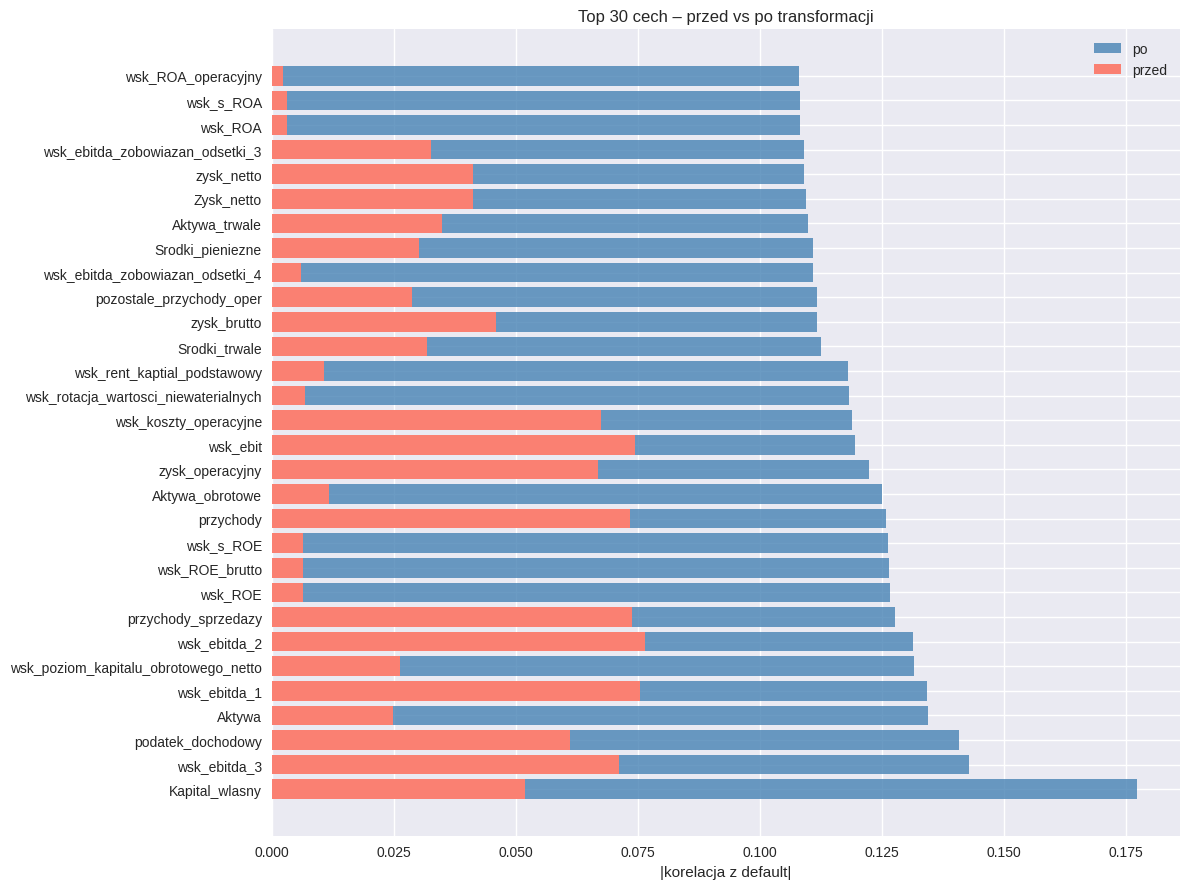

                                       przed      po
Kapital_wlasny                        0.0519  0.1772
wsk_ebitda_3                          0.0711  0.1428
podatek_dochodowy                     0.0610  0.1408
Aktywa                                0.0248  0.1345
wsk_ebitda_1                          0.0754  0.1341
wsk_poziom_kapitalu_obrotowego_netto  0.0262  0.1314
wsk_ebitda_2                          0.0765  0.1313
przychody_sprzedazy                   0.0738  0.1276
wsk_ROE                               0.0065  0.1266
wsk_ROE_brutto                        0.0064  0.1263
wsk_s_ROE                             0.0065  0.1263
przychody                             0.0734  0.1258
Aktywa_obrotowe                       0.0118  0.1250
zysk_operacyjny                       0.0668  0.1224
wsk_ebit                              0.0743  0.1194

Najlepsza po transformacji: Kapital_wlasny → |r| = 0.1772
Liczba cech z |r| > 0.20 po transformacji: 0
Liczba cech z |r| > 0.15 po transformacji: 1


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# -------------------------------------------------
# PORÓWNANIE KORELACJI Z TARGETEM – MINIMAL EDITION
# -------------------------------------------------

# surowe dane (przed jakąkolwiek transformacją)
raw = df_train.drop('default', axis=1, errors='ignore').select_dtypes('number')

# dane po Twojej transformacji
processed = X_train.select_dtypes('number')

# korelacje z default
before = raw.corrwith(df_train['default']).abs()
after  = processed.corrwith(df_train['default']).abs()

# ramka z wynikiem
df = pd.DataFrame({'przed': before, 'po': after}).sort_values('po', ascending=False)

# wykres – top 30
top30 = df.head(30)

plt.figure(figsize=(12, 9))
plt.barh(range(30, 0, -1), top30['po'],   color='steelblue', alpha=0.8, label='po')
plt.barh(range(30, 0, -1), top30['przed'], color='salmon', alpha=1, label='przed')
plt.yticks(range(30, 0, -1), top30.index)
plt.xlabel('|korelacja z default|')
plt.title('Top 30 cech – przed vs po transformacji')
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# podsumowanie w konsoli
print(df.head(15)[['przed', 'po']].round(4))
print("\nNajlepsza po transformacji:", df.index[0], "→ |r| =", df.iloc[0,1].round(4))
print("Liczba cech z |r| > 0.20 po transformacji:", (df['po'] > 0.20).sum())
print("Liczba cech z |r| > 0.15 po transformacji:", (df['po'] > 0.15).sum())

In [ ]:
import numpy as np

# ---------------------------------------------------------------
# Usuwanie cech o bardzo wysokiej korelacji (> 0.80) PO transformacjach
# ---------------------------------------------------------------

# Upewniamy się, że pracujemy tylko z kolumnami numerycznymi (po OHE, Yeo-Johnson, skalowaniu)
X_corr = X_train.select_dtypes(include=[np.number]).copy()

print(f"X_train shape przed usuwaniem wysokich korelacji: {X_train.shape}")

# Macierz korelacji (wartości bezwzględne)
corr_matrix = X_corr.corr().abs()

# Górny trójkąt (żeby nie dublować par)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Znajdź wszystkie pary o korelacji > 0.80
high_corr_pairs = [(i, j, corr_matrix.loc[i, j])
                   for i in upper_tri.index
                   for j in upper_tri.columns
                   if upper_tri.loc[i, j] > 0.80]

print(f"\nZnaleziono {len(high_corr_pairs)} par zmiennych z |r| > 0.80:")
for col1, col2, corr in high_corr_pairs[:20]:  # pokaż tylko pierwsze 20
    print(f"  {col1} ↔ {col2}: {corr:.3f}")
if len(high_corr_pairs) > 20:
    print("  ... i więcej")

# --- Inteligentne usuwanie: z każdej pary usuń tylko jedną zmienną ---
to_drop = set()
for col1, col2, _ in high_corr_pairs:
    if col1 not in to_drop and col2 not in to_drop:
        # Usuwamy tę, która ma średnio wyższą korelację z resztą cech
        # (to lepsze niż losowe usuwanie)
        mean_corr_col1 = corr_matrix[col1].drop(col2).mean()
        mean_corr_col2 = corr_matrix[col2].drop(col1).mean()
        if mean_corr_col1 > mean_corr_col2:
            to_drop.add(col1)
        else:
            to_drop.add(col2)

print(f"\nZmienne do usunięcia (po jednej z każdej pary): {len(to_drop)} szt.")
print("Usunięte kolumny:", sorted(to_drop))

# Usuwamy z X_train (i pamiętamy o dropped_cols, jeśli używasz tej listy)
if 'dropped_cols' not in globals():
    dropped_cols = []

dropped_cols.extend(to_drop)
X_train = X_train.drop(columns=to_drop)

print(f"\nX_train shape po usunięciu wysokich korelacji: {X_train.shape}")
print(f"Łącznie usunięto dotychczas kolumn: {len(dropped_cols)}")

X_train shape przed usuwaniem wysokich korelacji: (2100, 183)

Znaleziono 254 par zmiennych z |r| > 0.80:
  Aktywa ↔ Aktywa_obrotowe: 0.888
  Aktywa ↔ Kapital_wlasny: 0.917
  Aktywa ↔ Zobowiazania_rezerwy: 0.878
  Aktywa_trwale ↔ wsk_struktura_majatku: 0.819
  Rzeczowe_aktywa_trwale ↔ Srodki_trwale: 0.955
  Aktywa_obrotowe ↔ Naleznosci_krotkoterminowe: 0.858
  Aktywa_obrotowe ↔ Kapital_wlasny: 0.816
  Aktywa_obrotowe ↔ Zobowiazania_rezerwy: 0.831
  Aktywa_obrotowe ↔ przychody_sprzedazy: 0.819
  Aktywa_obrotowe ↔ przychody: 0.834
  Aktywa_obrotowe ↔ wsk_koszty_operacyjne: 0.830
  Zapasy ↔ wsk_rotacja_zapasow: 0.921
  Zapasy ↔ wsk_udzial_zapasy_zobowiazania: 0.830
  Zapasy ↔ wsk_udzial_zapasy_kap_obrotowy: 0.867
  Naleznosci_dostaw_uslug_12m_pozostale ↔ Zobowiazania_dostaw_uslug_12m_pozostale: 0.845
  Inwestycje_krotkoterminowe ↔ Srodki_pieniezne: 0.952
  Zysk_netto ↔ zysk_brutto: 0.977
  Zysk_netto ↔ zysk_netto: 0.982
  Zysk_netto ↔ wsk_ebit: 0.926
  Zobowiazania_rezerwy ↔ Zobowiazania_

Pozostało 91 numerycznych cech do analizy



Top 30 cech najbardziej skorelowanych z 'default' (po transformacji):
 1. Kapital_wlasny                                     → |r| = 0.1772
 2. wsk_ebitda_3                                       → |r| = 0.1428
 3. podatek_dochodowy                                  → |r| = 0.1408
 4. wsk_ebitda_1                                       → |r| = 0.1341
 5. wsk_poziom_kapitalu_obrotowego_netto               → |r| = 0.1314
 6. wsk_s_ROE                                          → |r| = 0.1263
 7. wsk_rotacja_wartosci_niewaterialnych               → |r| = 0.1181
 8. wsk_rent_kaptial_podstawowy                        → |r| = 0.1181
 9. pozostale_przychody_oper                           → |r| = 0.1117
10. Srodki_pieniezne                                   → |r| = 0.1108
11. Zysk_netto                                         → |r| = 0.1093
12. wsk_ebitda_zobowiazan_odsetki_3                    → |r| = 0.1090
13. koszty_operacyjne                                  → |r| = 0.1073
14. Rzeczowe_aktywa

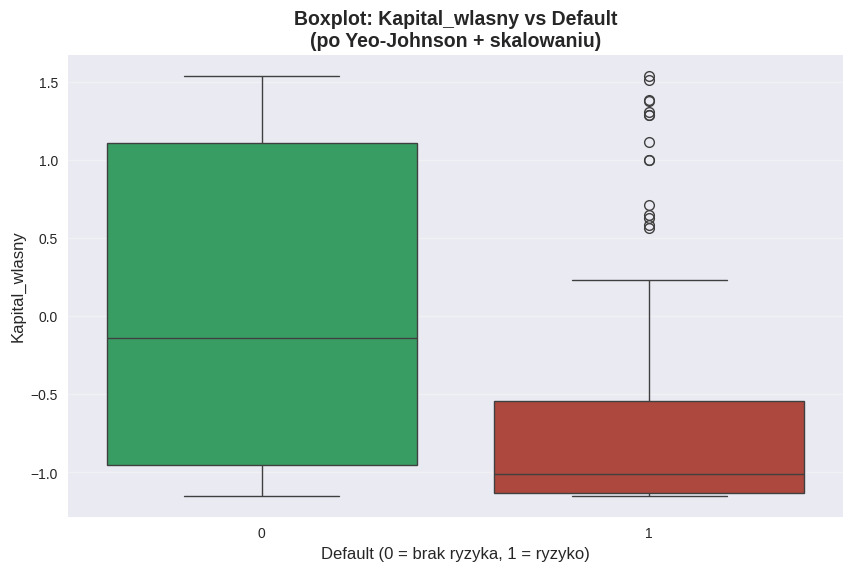

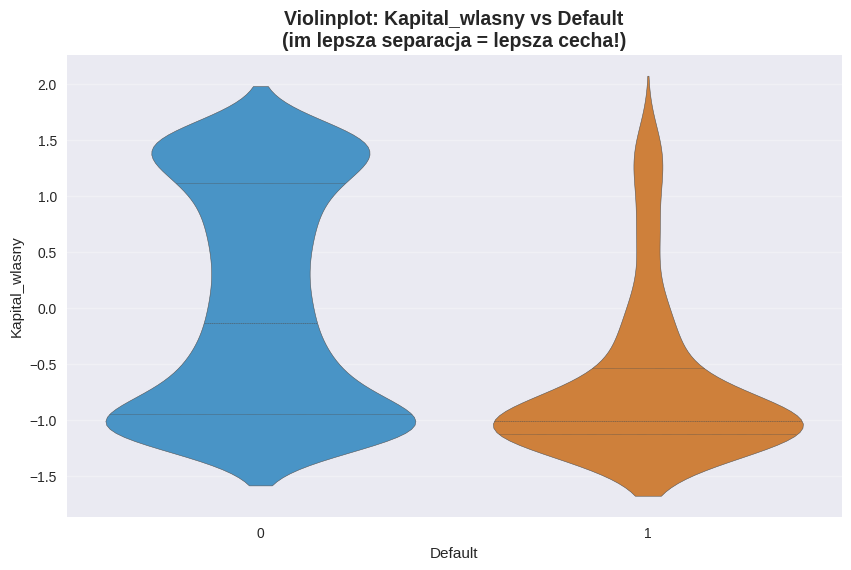

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ---------------------------------------------------------------
# 1. BEZPIECZNE przygotowanie danych – usuwa wszystkie kolumny tekstowe!
# ---------------------------------------------------------------
X_clean = X_train.copy()

# Usuwamy wszystkie kolumny, które nie są numeryczne (to zabija błąd 'SFJMI')
non_numeric_cols = X_clean.select_dtypes(include=['object', 'category', 'string']).columns
if len(non_numeric_cols) > 0:
    print(f"UWAGA: Usuwam kolumny nie-numeryczne (powód błędu): {list(non_numeric_cols)}")
    X_clean = X_clean.drop(columns=non_numeric_cols)

print(f"Pozostało {X_clean.shape[1]} numerycznych cech do analizy")

# Dodajemy target
df_for_corr = X_clean.copy()
df_for_corr['default'] = y_train.values  # .values – żeby indeksy się zgadzały

# ---------------------------------------------------------------
# 2. Top 30 cech najbardziej skorelowanych z default (Pearson)
# ---------------------------------------------------------------
correlations = df_for_corr.corr()['default'].abs().sort_values(ascending=False)
correlations = correlations.drop('default', errors='ignore')  # usuwamy samego siebie

top_30_features = correlations.head(30).index.tolist()

print("\nTop 30 cech najbardziej skorelowanych z 'default' (po transformacji):")
for i, feat in enumerate(top_30_features, 1):
    print(f"{i:2d}. {feat:<50} → |r| = {correlations[feat]:.4f}")

# ---------------------------------------------------------------
# 3. Boxplot + Violinplot dla najlepszej cechy
# ---------------------------------------------------------------
best_feature = top_30_features[0]
print(f"\nNajlepsza cecha: '{best_feature}' (|r| = {correlations[best_feature]:.4f})")

# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=y_train, y=X_clean[best_feature], palette=['#27ae60', '#c0392b'])
plt.title(f"Boxplot: {best_feature} vs Default\n(po Yeo-Johnson + skalowaniu)", fontsize=14, fontweight='bold')
plt.xlabel("Default (0 = brak ryzyka, 1 = ryzyko)", fontsize=12)
plt.ylabel(best_feature, fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.show()

# Violinplot – jeszcze lepiej pokazuje różnice!
plt.figure(figsize=(10, 6))
sns.violinplot(x=y_train, y=X_clean[best_feature], palette=['#3498db', '#e67e22'], inner='quartile')
plt.title(f"Violinplot: {best_feature} vs Default\n(im lepsza separacja = lepsza cecha!)", fontsize=14, fontweight='bold')
plt.xlabel("Default")
plt.ylabel(best_feature)
plt.grid(axis='y', alpha=0.3)
plt.show()

Top 30 najważniejszych cech (najsilniejsza korelacja z default):
 1. Kapital_wlasny → |r| = 0.1772
 2. wsk_ebitda_3 → |r| = 0.1428
 3. podatek_dochodowy → |r| = 0.1408
 4. wsk_ebitda_1 → |r| = 0.1341
 5. wsk_poziom_kapitalu_obrotowego_netto → |r| = 0.1314
 6. wsk_s_ROE → |r| = 0.1263
 7. wsk_rotacja_wartosci_niewaterialnych → |r| = 0.1181
 8. wsk_rent_kaptial_podstawowy → |r| = 0.1181
 9. pozostale_przychody_oper → |r| = 0.1117
10. Srodki_pieniezne → |r| = 0.1108
11. Zysk_netto → |r| = 0.1093
12. wsk_ebitda_zobowiazan_odsetki_3 → |r| = 0.1090
13. koszty_operacyjne → |r| = 0.1073
14. Rzeczowe_aktywa_trwale → |r| = 0.1071
15. Kapital_zapasowy → |r| = 0.1057
16. Rozliczenia_miedzyokresowe_krotkie → |r| = 0.1010
17. Naleznosci_dostaw_uslug_12m_pozostale → |r| = 0.0996
18. wsk_sytuacji_fin → |r| = 0.0970
19. Naleznosci_krotkoterminowe → |r| = 0.0962
20. zysk_sprzedazy → |r| = 0.0951
21. Zobowiazania_rezerwy → |r| = 0.0909
22. wsk_pokrycia_zobowiazan_rz_aktywami_trwalymi → |r| = 0.0888
23. w

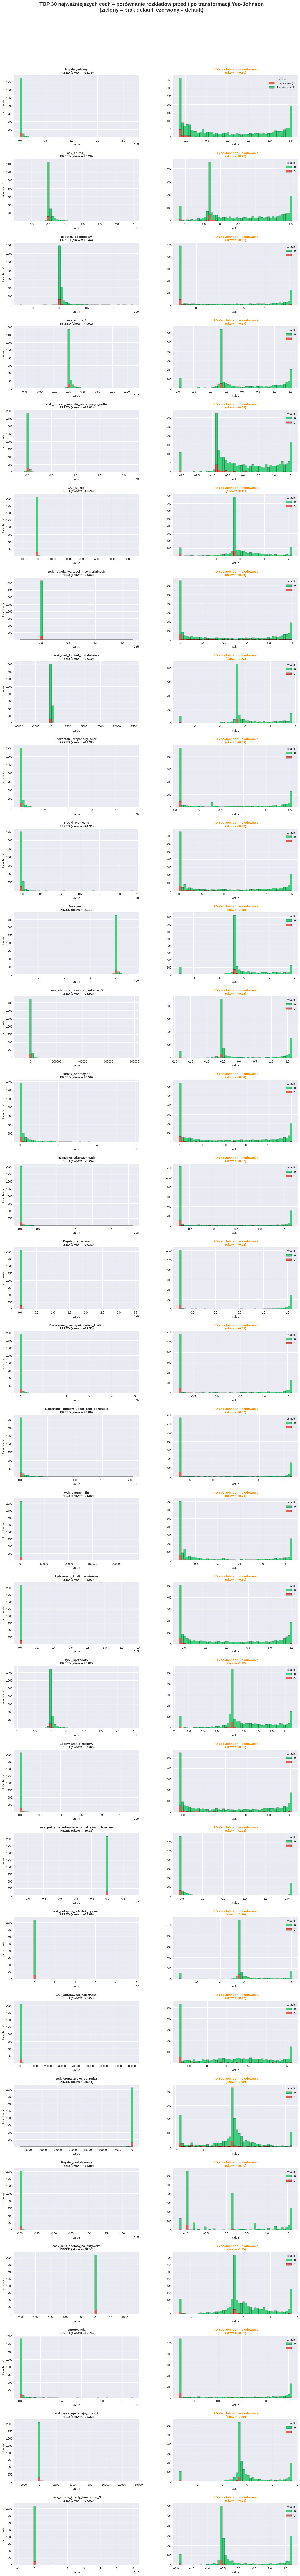

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ================================================
# 1. Wybór top 30 cech najbardziej skorelowanych z default
# ================================================
X_clean = X_train.select_dtypes(include=[np.number]).copy()  # usuwa SFJMI itp.

df_corr = X_clean.copy()
df_corr['default'] = y_train.values

# Korelacja Pearsona (bezwzględna)
correlations = df_corr.corr()['default'].abs().sort_values(ascending=False)
correlations = correlations.drop('default', errors='ignore')

top_30_features = correlations.head(30).index.tolist()

print(f"Top 30 najważniejszych cech (najsilniejsza korelacja z default):")
for i, f in enumerate(top_30_features, 1):
    print(f"{i:2d}. {f} → |r| = {correlations[f]:.4f}")

# ================================================
# 2. Dane przed transformacją – tylko te same 30 cech
# ================================================
X_before = df_train.drop(columns=['default'], errors='ignore')[top_30_features].copy()
X_before = X_before.select_dtypes(include=[np.number])  # ostateczne czyszczenie

# Jeśli jakaś cecha zniknęła (np. była tekstowa) – dopasuj listę
if X_before.shape[1] < 30:
    top_30_features = X_before.columns.tolist()
    X_clean = X_clean[top_30_features]

X_after = X_clean[top_30_features].copy()

# ================================================
# 3. Rysowanie – tylko 30 cech, po 2 wykresy (przed / po)
# ================================================
n_features = len(top_30_features)
fig = plt.figure(figsize=(18, 4.8 * n_features))
gs = fig.add_gridspec(n_features, 2, hspace=0.35, wspace=0.28)

for idx, feature in enumerate(top_30_features):
    row = idx

    # --- PRZED transformacją ---
    ax1 = fig.add_subplot(gs[row, 0])
    temp_b = pd.DataFrame({'value': X_before[feature], 'default': y_train})
    sns.histplot(data=temp_b, x='value', hue='default', bins=50, multiple='stack',
                 palette=['#2ecc71', '#e74c3c'], alpha=0.9, ax=ax1, legend=False)
    skew_b = X_before[feature].skew()
    ax1.set_title(f"{feature}\nPRZED (skew = {skew_b:+.2f})", fontweight='bold', fontsize=11)
    ax1.set_ylabel("Liczebność")

    # --- PO transformacji ---
    ax2 = fig.add_subplot(gs[row, 1])
    temp_a = pd.DataFrame({'value': X_after[feature], 'default': y_train})
    sns.histplot(data=temp_a, x='value', hue='default', bins=50, multiple='stack',
                 palette=['#2ecc71', '#e74c3c'], alpha=0.9, ax=ax2)
    skew_a = X_after[feature].skew()
    ax2.set_title(f"PO Yeo-Johnson + skalowanie\n(skew = {skew_a:+.2f})",
                  fontweight='bold', color='darkorange', fontsize=11)
    ax2.set_ylabel("")

    # Legenda tylko raz (w prawym górnym rogu pierwszego wykresu)
    if idx == 0:
        ax2.legend(['Bezpieczny (0)', 'Ryzykowny (1)'], title='default', loc='upper right')

# Tytuł główny
plt.suptitle("TOP 30 najważniejszych cech – porównanie rozkładów przed i po transformacji Yeo-Johnson\n"
             "(zielony = brak default, czerwony = default)",
             fontsize=18, fontweight='bold', y=0.985)

plt.tight_layout()
plt.subplots_adjust(top=0.96)
plt.show()

TOP 30 cech najbardziej skorelowanych z zmienną 'default'
po winsorize + Yeo-Johnson + skalowaniu:

Kapital_wlasny                                  0.1772
wsk_ebitda_3                                    0.1428
podatek_dochodowy                               0.1408
wsk_ebitda_1                                    0.1341
wsk_poziom_kapitalu_obrotowego_netto            0.1314
wsk_s_ROE                                       0.1263
wsk_rotacja_wartosci_niewaterialnych            0.1181
wsk_rent_kaptial_podstawowy                     0.1181
pozostale_przychody_oper                        0.1117
Srodki_pieniezne                                0.1108
Zysk_netto                                      0.1093
wsk_ebitda_zobowiazan_odsetki_3                 0.1090
koszty_operacyjne                               0.1073
Rzeczowe_aktywa_trwale                          0.1071
Kapital_zapasowy                                0.1057
Rozliczenia_miedzyokresowe_krotkie              0.1010
Naleznosci_dostaw_us

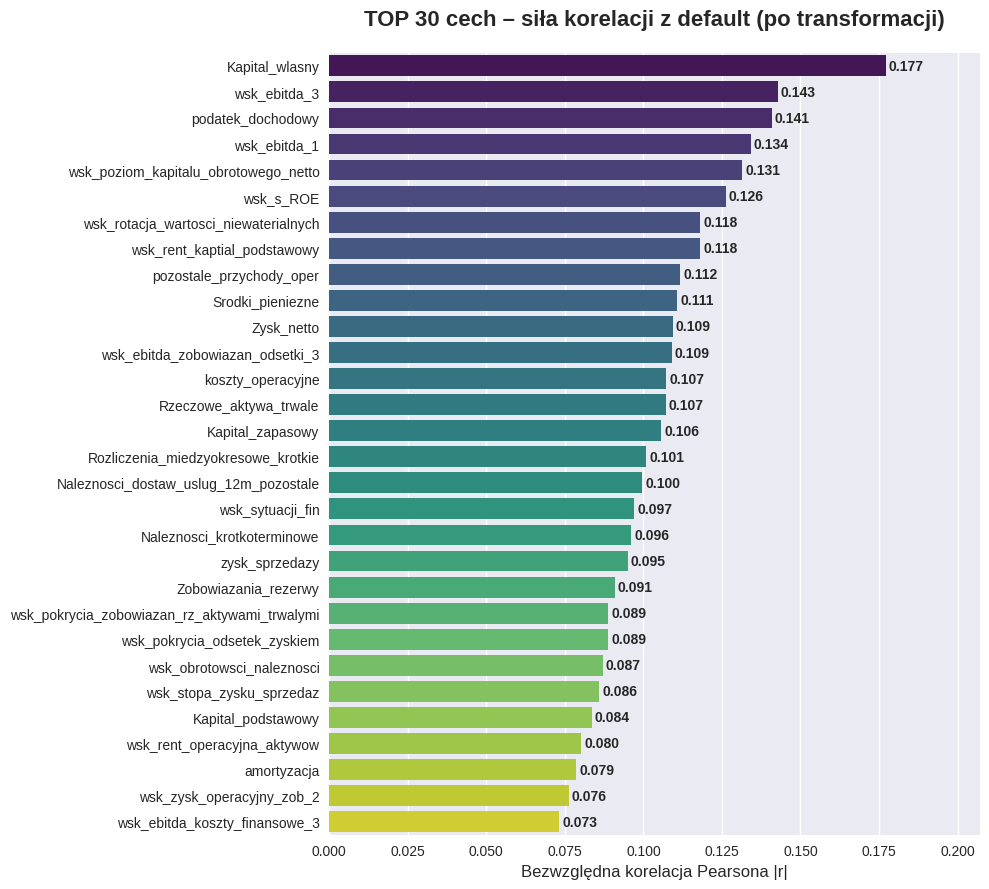


Podsumowanie siły predyktorów po transformacji:
• |r| > 0.20 → 0 cech ← bardzo mocne!
• |r| > 0.15 → 1 cech
• |r| > 0.10 → 16 cech
• |r| > 0.05 → 49 cech
Najlepsza cecha: 'Kapital_wlasny' z |r| = 0.1772


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Tworzymy tymczasowy df z targetem
df_corr_final = X_train.copy()
df_corr_final['default'] = y_train.values

# Obliczamy bezwzględną korelację Pearsona z targetem
correlations = df_corr_final.corr()['default'].abs().sort_values(ascending=False)
correlations = correlations.drop('default', errors='ignore')  # usuwamy samego siebie

# Top 30
top_30 = correlations.head(30)

print("TOP 30 cech najbardziej skorelowanych z zmienną 'default'")
print("po winsorize + Yeo-Johnson + skalowaniu:\n")
print(top_30.round(4).to_string())

# ========================================================
# Piękny wykres słupkowy (poziomy)
# ========================================================
plt.figure(figsize=(10, 9))
sns.barplot(x=top_30.values, y=top_30.index, palette="viridis")

plt.title("TOP 30 cech – siła korelacji z default (po transformacji)",
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Bezwzględna korelacja Pearsona |r|", fontsize=12)
plt.ylabel("")

# Dodajemy wartości na końcu słupków
for i, (feat, val) in enumerate(top_30.items()):
    plt.text(val + 0.001, i, f"{val:.3f}", va='center', fontsize=10, fontweight='bold')

plt.xlim(0, top_30.max() + 0.03)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

# ========================================================
# Bonus: ile cech ma |r| > 0.1? > 0.15? > 0.2?
# ========================================================
print("\nPodsumowanie siły predyktorów po transformacji:")
print(f"• |r| > 0.20 → { (correlations > 0.20).sum() } cech ← bardzo mocne!")
print(f"• |r| > 0.15 → { (correlations > 0.15).sum() } cech")
print(f"• |r| > 0.10 → { (correlations > 0.10).sum() } cech")
print(f"• |r| > 0.05 → { (correlations > 0.05).sum() } cech")
print(f"Najlepsza cecha: '{top_30.index[0]}' z |r| = {top_30.iloc[0]:.4f}")